In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import display, Markdown
%matplotlib inline  
from IPython.display import FileLink, FileLinks
import glob
from scipy import stats
import numpy as np

In [3]:
df = pd.read_csv('./pilot.csv')
df['logs'] = df['logs'].map(lambda x: json.loads(x) if not pd.isnull(x) else pd.NA)

df.loc[df['participant_id'].isna(),'participant_id'] = 'test'
df['__INDEX__'] = df['__INDEX__'].map(json.loads)

df.loc[df['participant_id'] == 'arnav','participant_id'] = "1"
df.loc[df['participant_id'] == 'karthik','participant_id'] = "2"
df.loc[df['participant_id'] == 'majeed','participant_id'] = "3"
df = df[~df.participant_id.isin(["bdog","9jsrk50xr9c-default","test","p6p94dhwo5-default","blaine", "unknown", "1", "2", "3"])].copy()

def find_start(x):
    if type(x) != list:
        return pd.NA
    
    for log in x:
        if log['type'] == 'START':
            return log['timestamp']
    
    return pd.NA

def find_end(x):
    if type(x) != list:
        return pd.NA
    for log in x:
        if log['type'] == 'END':
            return log['timestamp']
    
    return pd.NA


def extract_metadata(x):
#     print(pd.Series(json.loads(x['metadata'])))
    d = json.loads(x['metadata'])
    if 'participant_id' in d:
        del d['participant_id']
    return pd.Series(d)
   

In [4]:
# TODO: I accidentally made it so that if there is no menu it is baseline. If there is a menu and it is baseline then it is something else -_-

In [5]:
def fix_menu_labels(row):
    if row['task'] == 'DivergentTest':
        if row['version'] == 'prolific-pilot@2':
            if row['menu'] == 'baseline':
                row['menu'] = json.loads(row['order'])[row['__INDEX__'][0] - 4]
            elif pd.isna(row['menu']):
                row['menu'] = 'baseline'
    return row
df = df.apply(fix_menu_labels, axis=1)

In [6]:
# df[df['task'] == 'DivergentTest'].groupby(['participant_id', 'menu']).count()

In [7]:
 

df['start'] = df['logs'].map(find_start)
df['end'] = df['logs'].map(find_end)
# df = df.apply(find_random_pid, axis=1)
df = pd.concat([df, df.apply(extract_metadata, axis=1)], axis=1)


df['menu'] = df.menu.astype("category")
df.menu = df.menu.cat.reorder_categories(['baseline', 'ToolPalette', 'KeyboardShortcutsWithCheatsheet', 'MarkingMenu'])
df.menu = df.menu.cat.rename_categories({'KeyboardShortcutsWithCheatsheet' : 'Keyboard Shortcuts', 'MarkingMenu' : 'Marking Menu', 'ToolPalette' : 'Tool Palette', 'baseline' : 'Baseline'})

In [8]:
def rename_participants(x):
#     print(x['participant_id'])
#     print(pd.isna(x['participant_id']))
    
    if pd.isna(x['participant_id']) or x['participant_id'] == 'unknown':
        x['participant_id'] = x['participant']
    return x
df = df.apply(rename_participants, axis=1)

In [9]:
demographics = pd.concat([pd.read_csv(p) for p in glob.glob('../data/prolific_export*.csv')])
demographics['participant_id'] = demographics['Participant id']

df = df.merge(demographics, on='participant_id', how="left")


In [10]:
# df['Age'] = df['Age'].replace('DATA_EXPIRED', pd.NA)
df['Age'] = pd.to_numeric(df['Age'],errors='coerce')
df['Age'].unique()

array([37., 30., 36., 38., 25., 32., 61., 42., 35., 31., 34., 29., 24.,
       21., 33., 27., 26., 53., nan, 22., 39., 20., 40., 23., 46., 45.,
       28.])

In [11]:
gdf = df.groupby(['participant_id']).agg({'start' : 'min', 'end' : 'max'}).reset_index()
gdf['duration'] = gdf['end'] - gdf['start']
gdf['duration_minutes'] = gdf['duration'] / 1000 / 60

<AxesSubplot: xlabel='duration_minutes', ylabel='Count'>

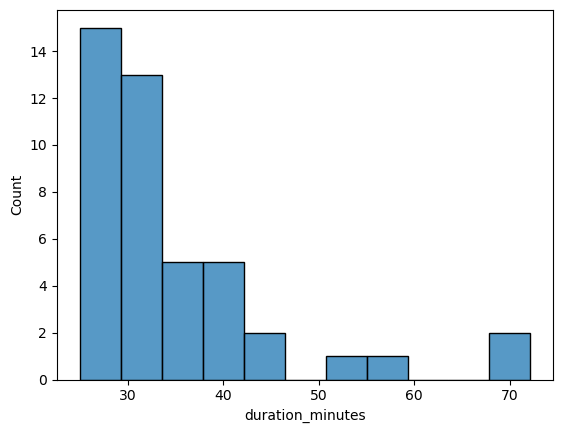

In [12]:
sns.histplot(data=gdf, x="duration_minutes")

In [53]:
gdf[(np.abs(stats.zscore(gdf['duration_minutes'])) >= 3)]

,participant_id,start,end,duration,duration_minutes
0,5a03d20a7ecfc50001be0a7a,1675990195519,1675994387760,4192241,69.870683
9,5cfb5233df7d70001619ca90,1675984485039,1675988816984,4331945,72.199083


In [13]:
participants = df.drop_duplicates(subset='participant_id')

<AxesSubplot: xlabel='Age', ylabel='Count'>

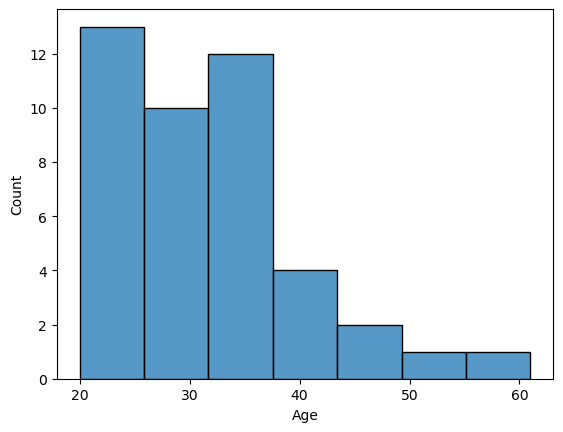

In [14]:
sns.histplot(data=participants, x="Age")

In [15]:
participants[["Age"]].describe()

,Age
count,43.000000
mean,31.860465
std,8.733028
min,20.000000
25%,25.000000
50%,31.000000
75%,37.000000
max,61.000000


<AxesSubplot: xlabel='Sex', ylabel='count'>

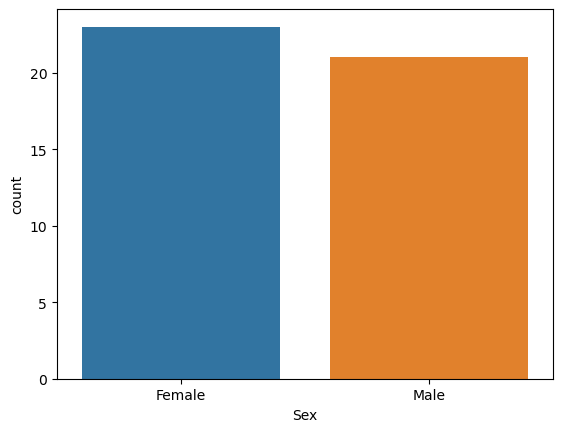

In [16]:
sns.countplot(data=participants, x="Sex")

<AxesSubplot: xlabel='order', ylabel='count'>

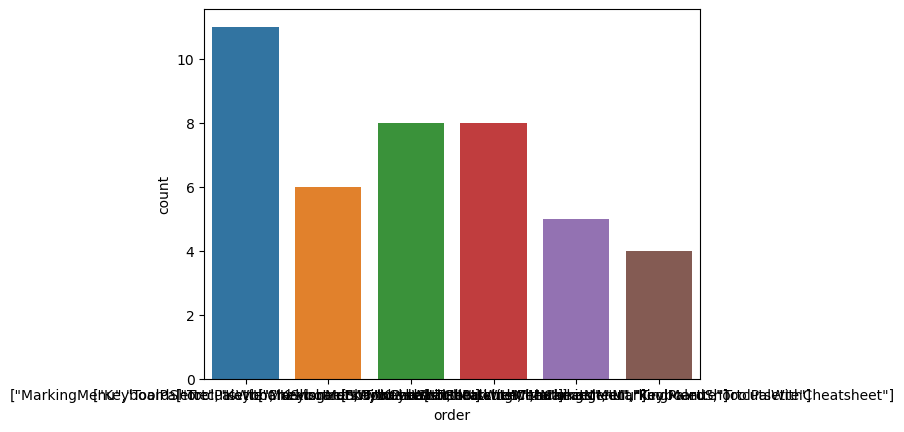

In [17]:
sns.countplot(data=participants, x="order")

In [18]:
demographics.columns

Index(['Submission id', 'Participant id', 'Status', 'Started at',
       'Completed at', 'Reviewed at', 'Archived at', 'Time taken',
       'Completion code', 'Total approvals', 'Fluent languages', 'Age', 'Sex',
       'Ethnicity simplified', 'Country of birth', 'Country of residence',
       'Nationality', 'Language', 'Student status', 'Employment status',
       'participant_id'],
      dtype='object')

In [19]:
df.menu.unique()

array([nan, 'Baseline', 'Marking Menu', 'Tool Palette',
       'Keyboard Shortcuts'], dtype=object)

# Dataframe Creation

## Selection

In [20]:
selection = df[df['task'] == 'CommandSelection'].copy()

def extract_selection(row):
    errors = 0
    start = None
    end = None
    for log in row['logs']:
        if log['type'] == 'WRONG_COMMAND':
            errors += 1
        if log['type'] == 'START':
            start = log['timestamp']
        if log['type'] == 'END':
            end = log['timestamp']
    row['errors'] = errors
    row['has_error'] = errors > 0
    row['duration_milliseconds'] = end - start
    row['duration_minutes'] = row['duration_milliseconds'] / 1000 / 60
    return row

selection['trial'] = selection['__INDEX__'].map(lambda x: x[2])
selection['trial_total'] = selection['__INDEX__'].map(lambda x: x[0] * x[1])

selection = selection[['participant_id', '__INDEX__', 'logs', 'command', 'trial','trial_total', 'menu']]

selection = selection.apply(extract_selection, axis=1)
selection['menu'] = selection.menu.astype("category")

In [62]:
selection

,participant_id,__INDEX__,logs,command,trial,trial_total,menu,errors,has_error,duration_milliseconds,duration_minutes
6,5a03d20a7ecfc50001be0a7a,"[4, 1, 1]","[{'type': 'START', 'timestamp': 1675990603384}...",Print,1,4,Marking Menu,21,True,105402,1.756700
8,5a03d20a7ecfc50001be0a7a,"[4, 1, 3]","[{'type': 'START', 'timestamp': 1675990710062}...",Italic,3,4,Marking Menu,0,False,7846,0.130767
10,5a03d20a7ecfc50001be0a7a,"[4, 1, 5]","[{'type': 'START', 'timestamp': 1675990719262}...",Redo,5,4,Marking Menu,0,False,14974,0.249567
12,5a03d20a7ecfc50001be0a7a,"[4, 1, 7]","[{'type': 'START', 'timestamp': 1675990735077}...",Undo,7,4,Marking Menu,0,False,6262,0.104367
14,5a03d20a7ecfc50001be0a7a,"[4, 1, 9]","[{'type': 'START', 'timestamp': 1675990742156}...",Bold,9,4,Marking Menu,0,False,5424,0.090400
...,...,...,...,...,...,...,...,...,...,...,...
14150,63d142821569b5debdfdf1d7,"[6, 1, 91]","[{'type': 'START', 'timestamp': 1675987133794}...",Undo,91,6,Tool Palette,0,False,946,0.015767
14152,63d142821569b5debdfdf1d7,"[6, 1, 93]","[{'type': 'START', 'timestamp': 1675987135686}...",Undo,93,6,Tool Palette,0,False,1427,0.023783
14154,63d142821569b5debdfdf1d7,"[6, 1, 95]","[{'type': 'START', 'timestamp': 1675987138350}...",Insert link,95,6,Tool Palette,0,False,1564,0.026067
14156,63d142821569b5debdfdf1d7,"[6, 1, 97]","[{'type': 'START', 'timestamp': 1675987140926}...",Redo,97,6,Tool Palette,0,False,1272,0.021200


In [21]:
counts = selection.groupby(['participant_id','menu']).count()
assert len(counts[counts['logs'] != 50]) == 0

<AxesSubplot: xlabel='duration_milliseconds', ylabel='Count'>

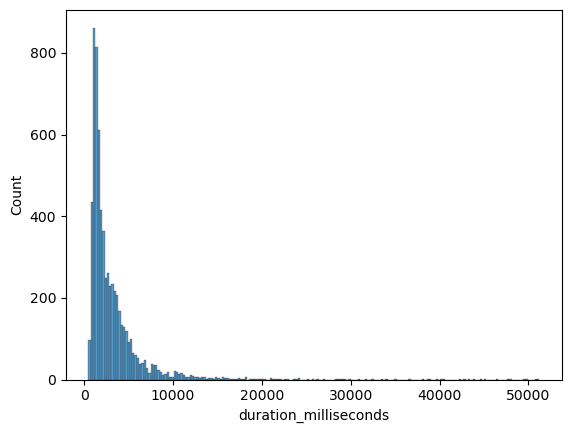

In [64]:
# plt.axvline(2.8, 0,0.17)
no_outliers = selection[(np.abs(stats.zscore(selection['duration_milliseconds'])) < 3)]

sns.histplot(data=no_outliers, x='duration_milliseconds')

In [58]:
selection[(np.abs(stats.zscore(selection['duration_milliseconds'])) >= 3)]

,participant_id,__INDEX__,logs,command,trial,trial_total,menu,errors,has_error,duration_milliseconds,duration_minutes
6,5a03d20a7ecfc50001be0a7a,"[4, 1, 1]","[{'type': 'START', 'timestamp': 1675990603384}...",Print,1,4,Marking Menu,21,True,105402,1.756700
218,5a03d20a7ecfc50001be0a7a,"[6, 1, 3]","[{'type': 'START', 'timestamp': 1675992830261}...",Redo,3,6,Keyboard Shortcuts,0,False,491352,8.189200
256,5a03d20a7ecfc50001be0a7a,"[6, 1, 41]","[{'type': 'START', 'timestamp': 1675993481622}...",Italic,41,6,Keyboard Shortcuts,0,False,361091,6.018183
1937,5c6480b5f9b6300001c9d52c,"[4, 1, 1]","[{'type': 'START', 'timestamp': 1675984020297}...",Bold,1,4,Marking Menu,62,True,116480,1.941333
2259,5c90094e71f3100016181ea9,"[4, 1, 1]","[{'type': 'START', 'timestamp': 1675985475819}...",Print,1,4,Marking Menu,27,True,186680,3.111333
2471,5c90094e71f3100016181ea9,"[6, 1, 3]","[{'type': 'START', 'timestamp': 1675987031446}...",Bold,3,6,Keyboard Shortcuts,20,True,101879,1.697983
2473,5c90094e71f3100016181ea9,"[6, 1, 5]","[{'type': 'START', 'timestamp': 1675987136402}...",Spellcheck,5,6,Keyboard Shortcuts,17,True,74308,1.238467
2477,5c90094e71f3100016181ea9,"[6, 1, 9]","[{'type': 'START', 'timestamp': 1675987255871}...",Undo,9,6,Keyboard Shortcuts,19,True,67746,1.129100
2509,5c90094e71f3100016181ea9,"[6, 1, 41]","[{'type': 'START', 'timestamp': 1675987574649}...",Align Justify,41,6,Keyboard Shortcuts,30,True,59520,0.992000
2523,5c90094e71f3100016181ea9,"[6, 1, 55]","[{'type': 'START', 'timestamp': 1675987708766}...",Italic,55,6,Keyboard Shortcuts,22,True,63897,1.064950


In [65]:
selection = selection[(np.abs(stats.zscore(selection['duration_milliseconds'])) < 3)]

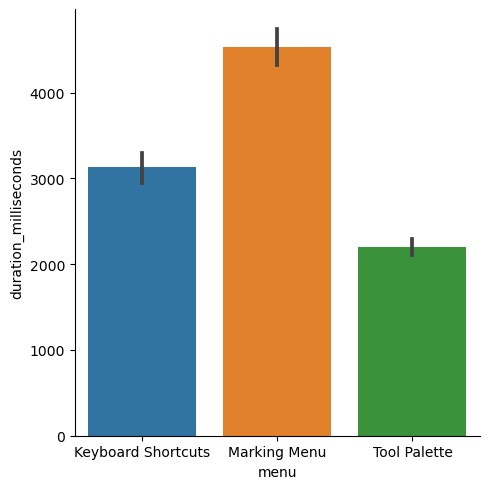

In [66]:
sns.catplot(data=selection, kind="bar", x='menu', y='duration_milliseconds')

/var/folders/6y/lbzmz4lj6xb8933np1_x1xgm0000gn/T/ipykernel_6492/2403373394.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.catplot(data=selection.groupby(['participant_id','menu']).sum().reset_index(), kind="bar", x='menu', y='duration_minutes')


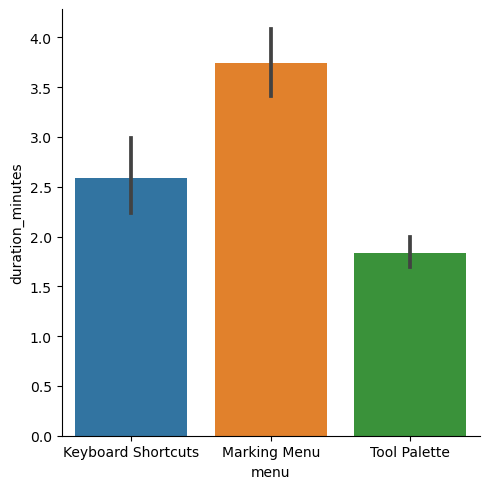

In [67]:
sns.catplot(data=selection.groupby(['participant_id','menu']).sum().reset_index(), kind="bar", x='menu', y='duration_minutes')

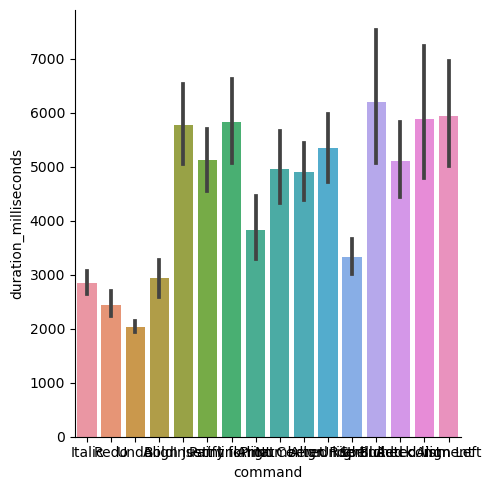

In [68]:
sns.catplot(data=selection, kind="bar", x='command', y='duration_milliseconds')

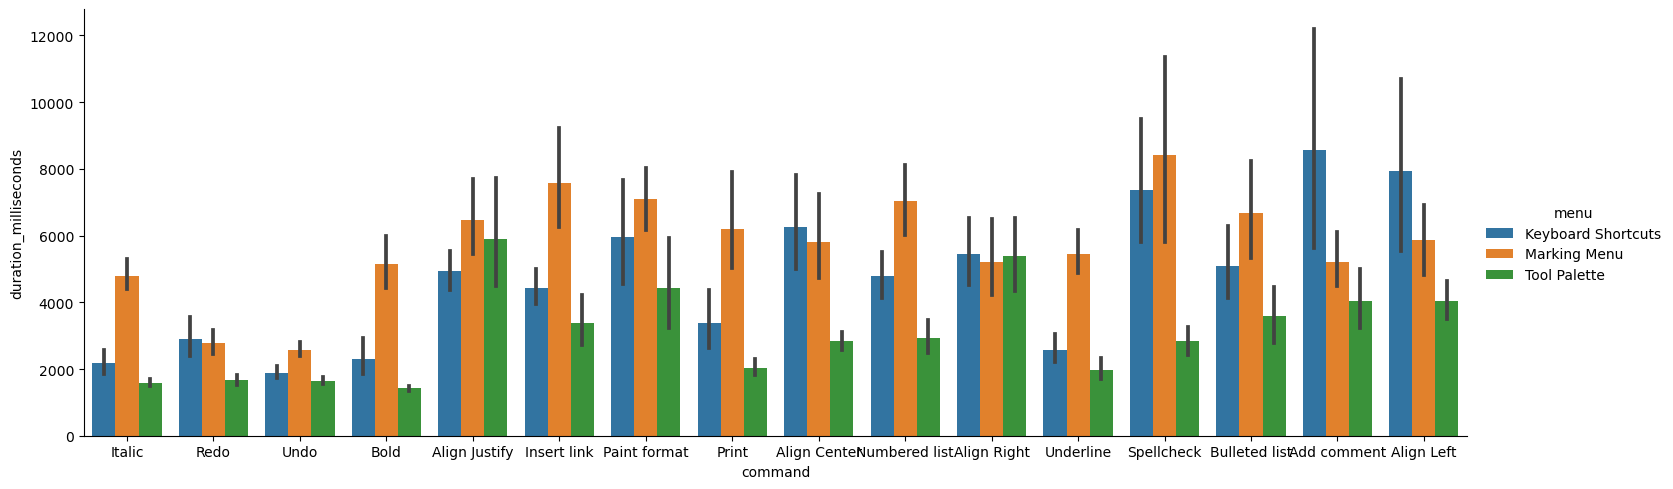

In [69]:
sns.catplot(data=selection, kind="bar", hue="menu", x='command', y='duration_milliseconds', height=5, aspect=15/5)

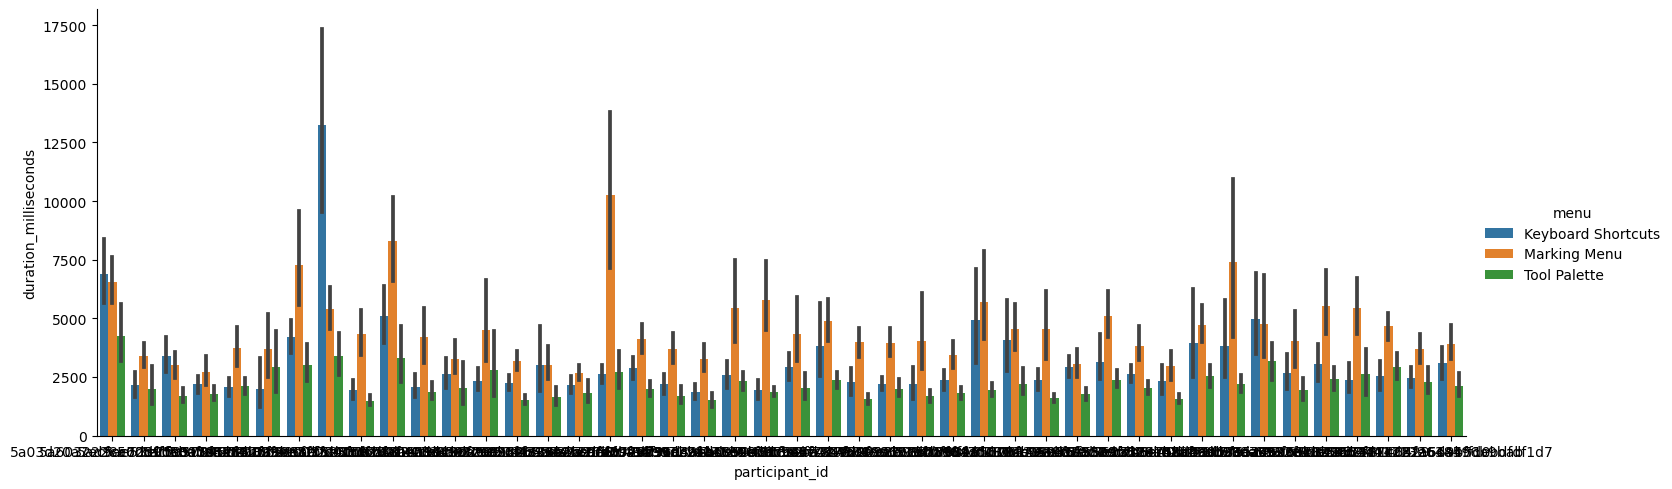

In [70]:
sns.catplot(data=selection, kind="bar", hue="menu", x='participant_id', y='duration_milliseconds', height=5, aspect=15/5)

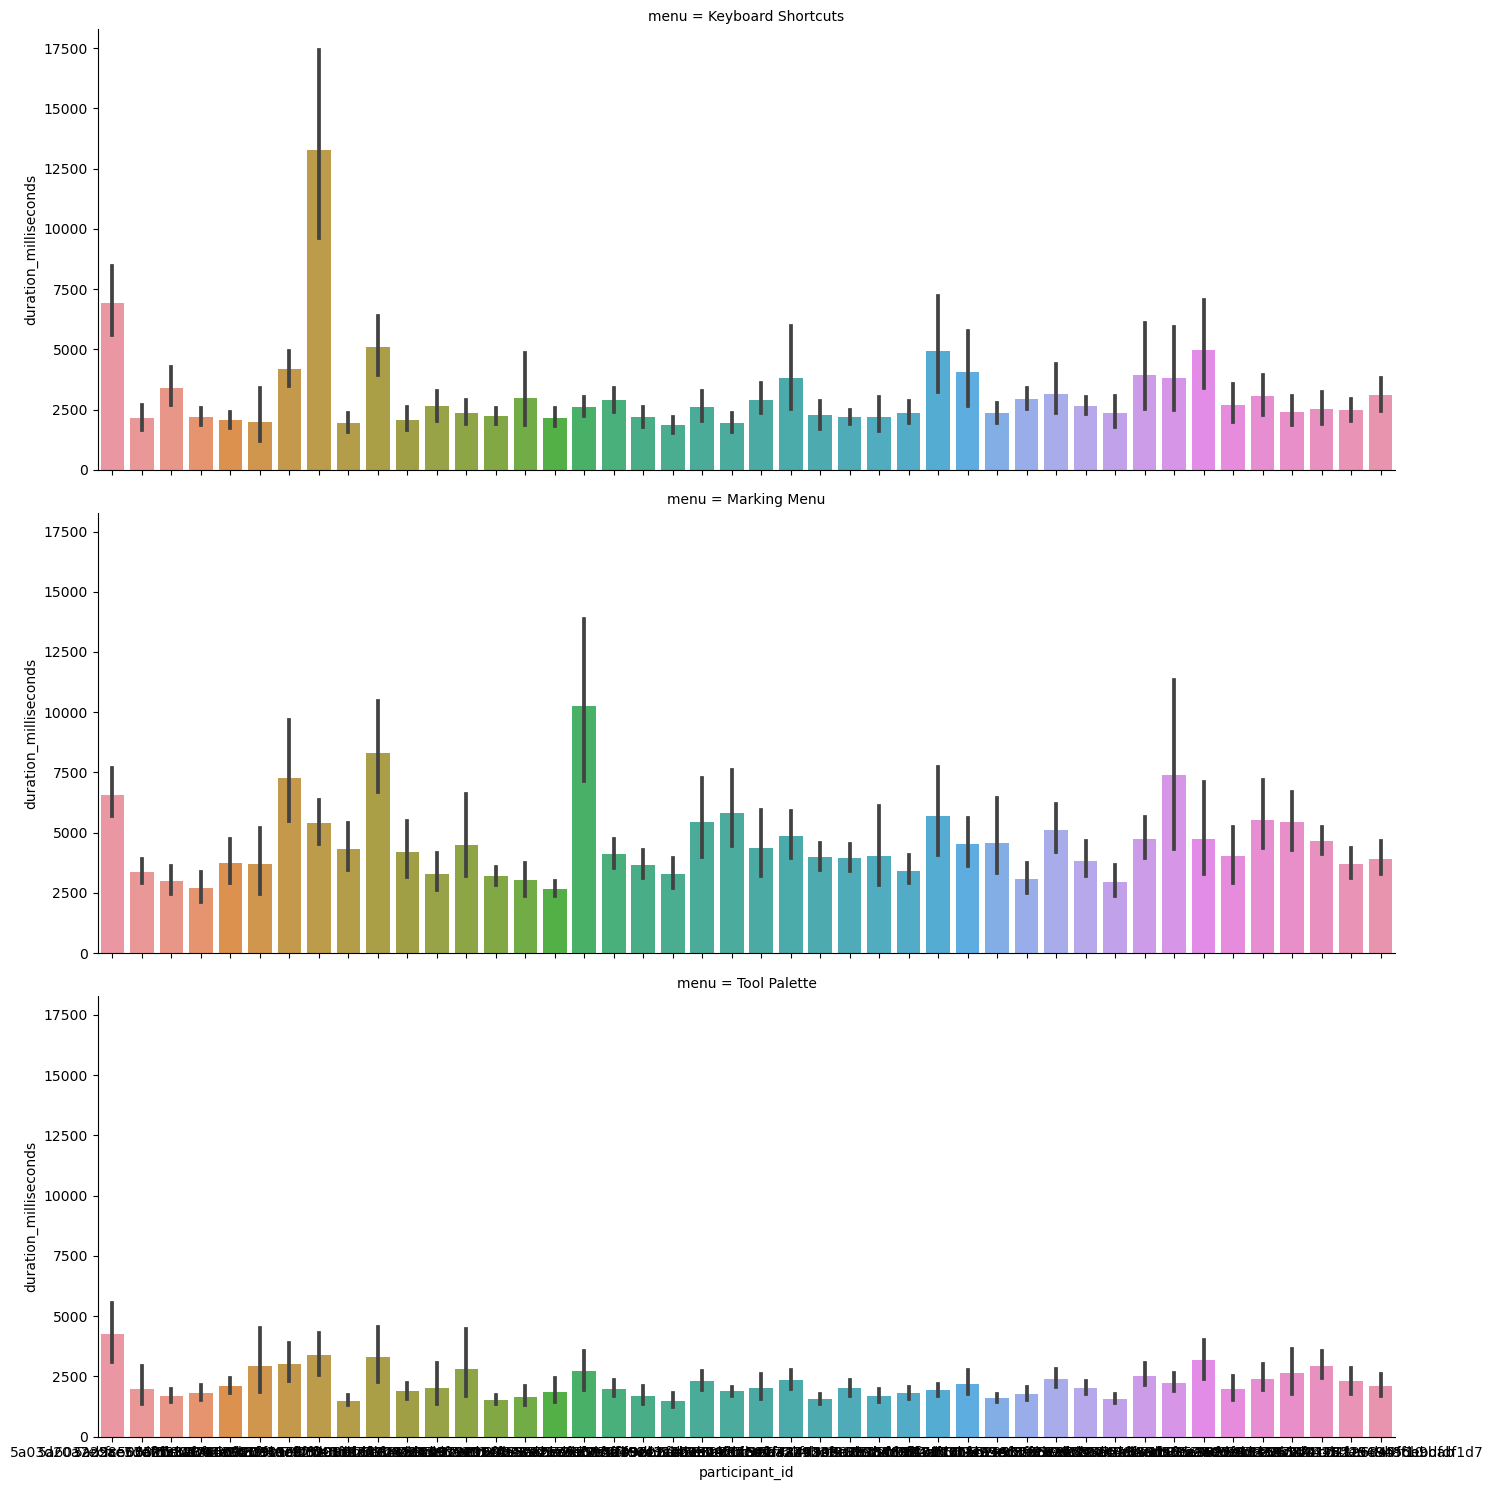

In [71]:
sns.catplot(data=selection, kind="bar", x='participant_id', y='duration_milliseconds', row='menu', height=5, aspect=15/5)

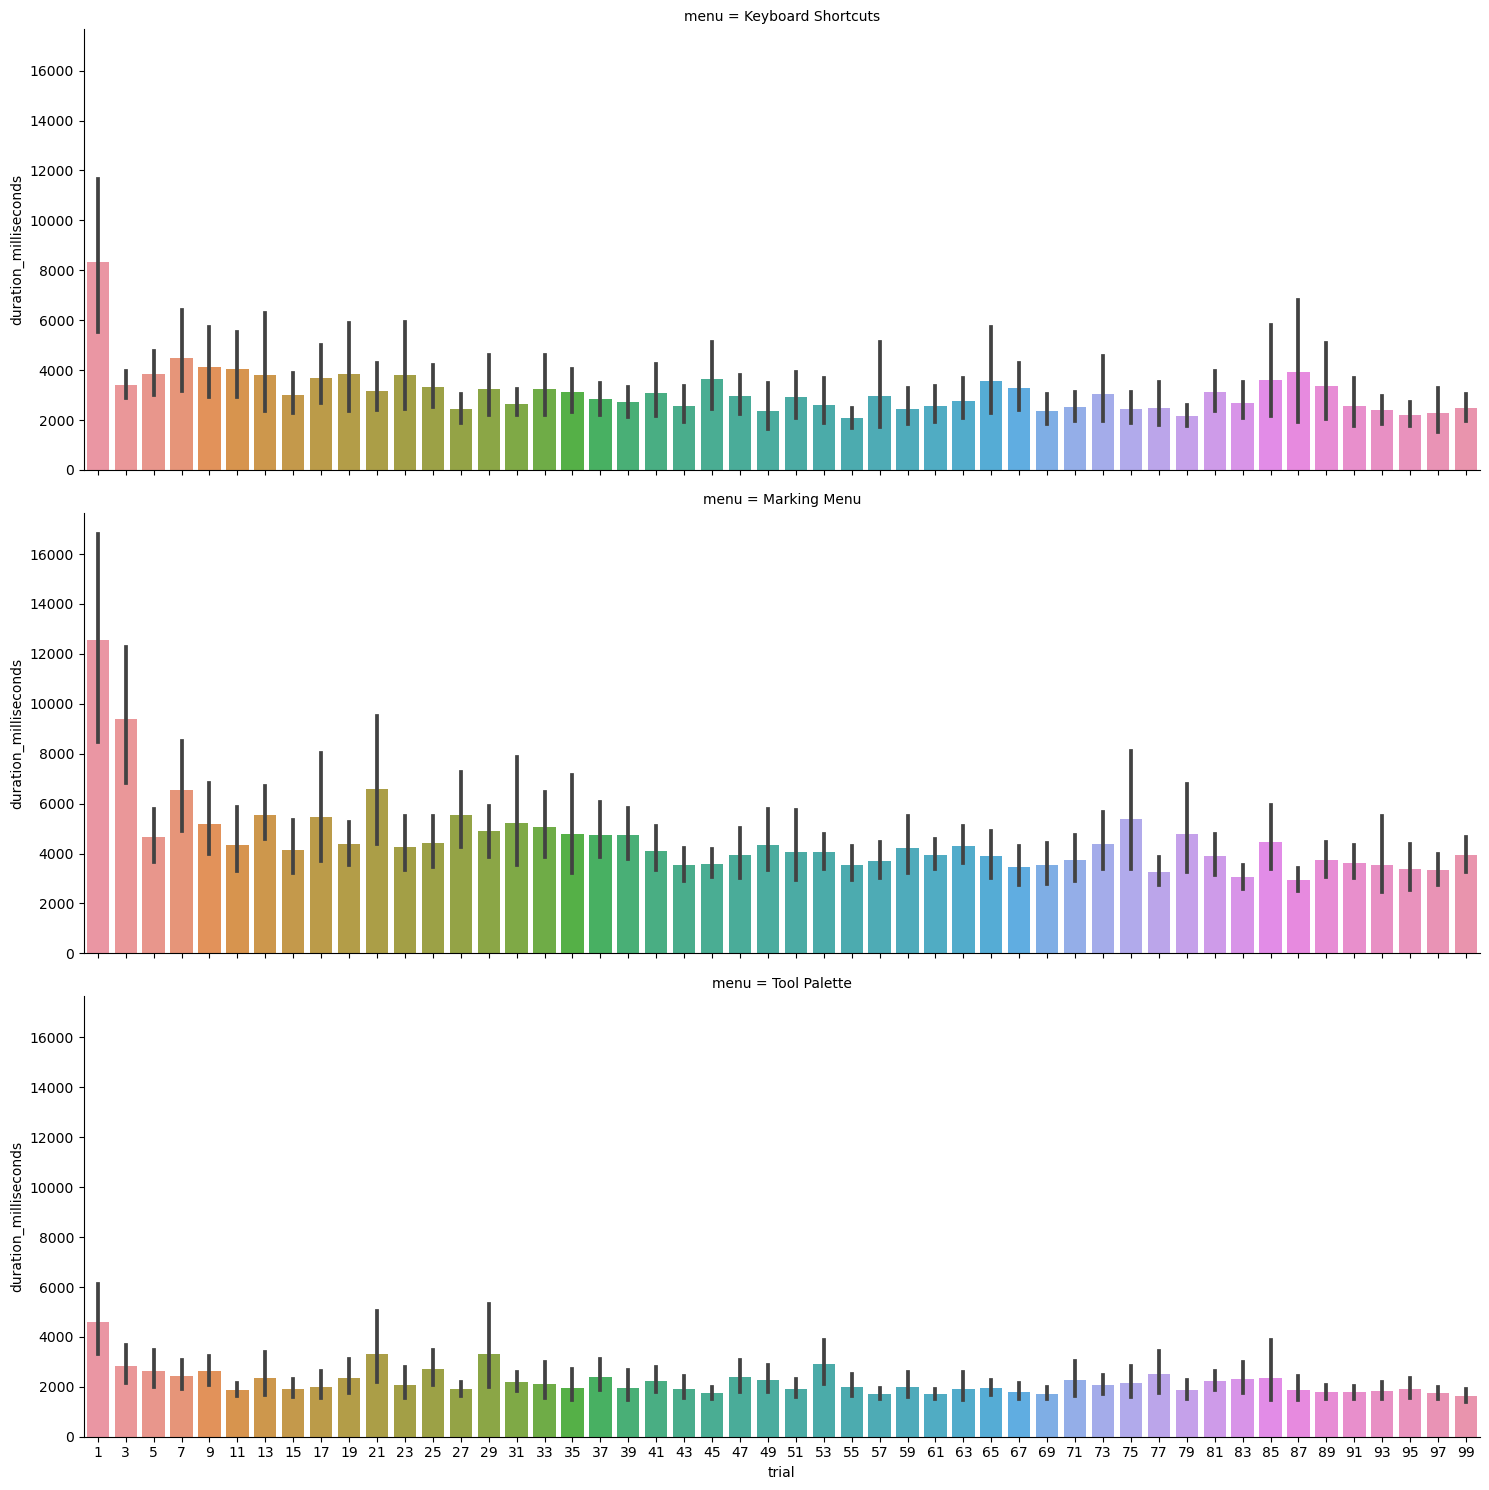

In [72]:
sns.catplot(data=selection, kind="bar", x='trial', y='duration_milliseconds', row='menu', height=5, aspect=15/5)

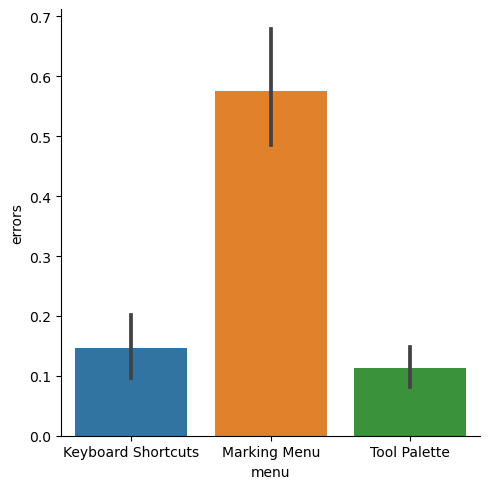

In [73]:
sns.catplot(data=selection, kind="bar", x='menu', y='errors')

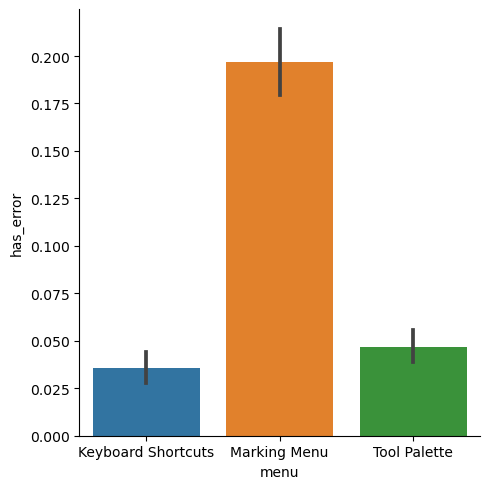

In [74]:
sns.catplot(data=selection, kind="bar", x='menu', y='has_error')

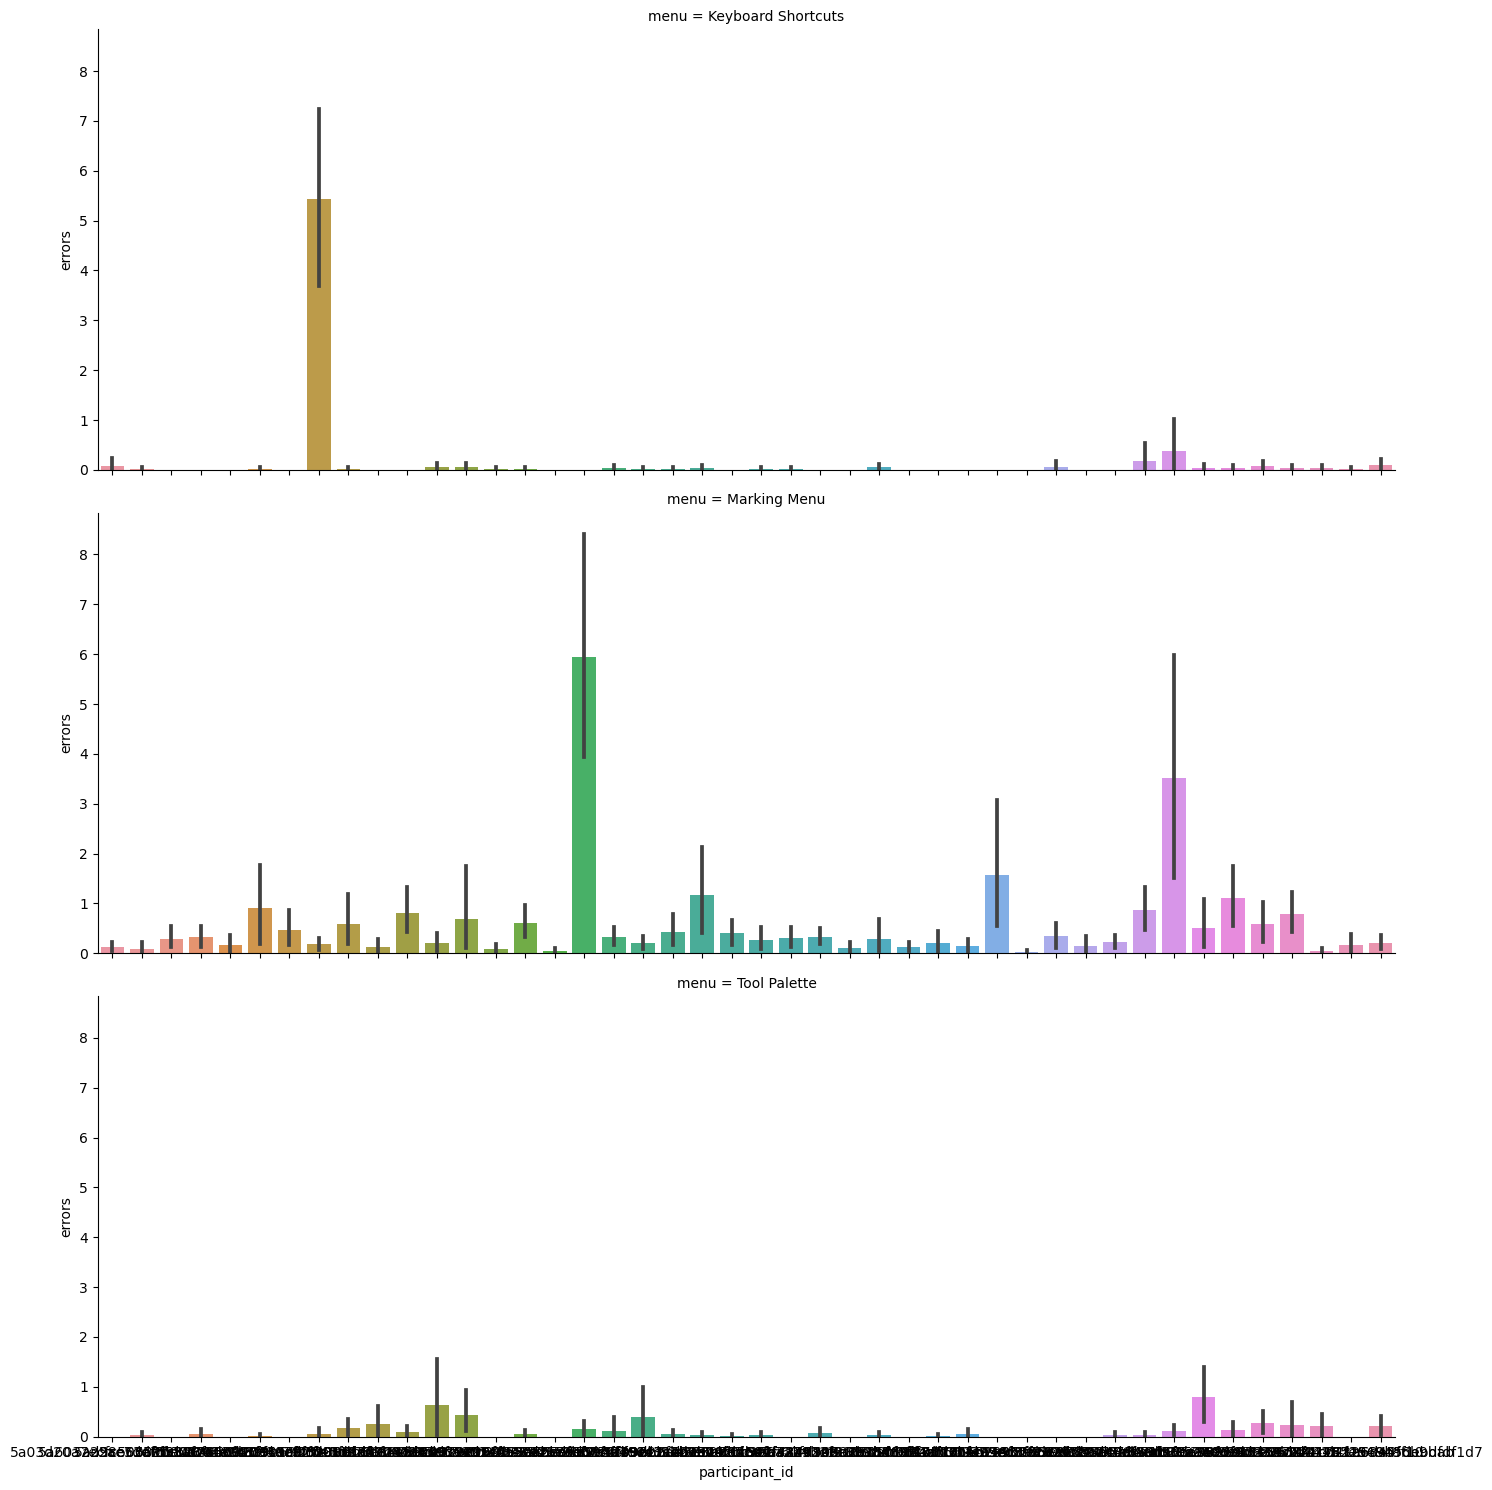

In [75]:
sns.catplot(data=selection, kind="bar", x='participant_id', y='errors', row='menu', height=5, aspect=15/5)

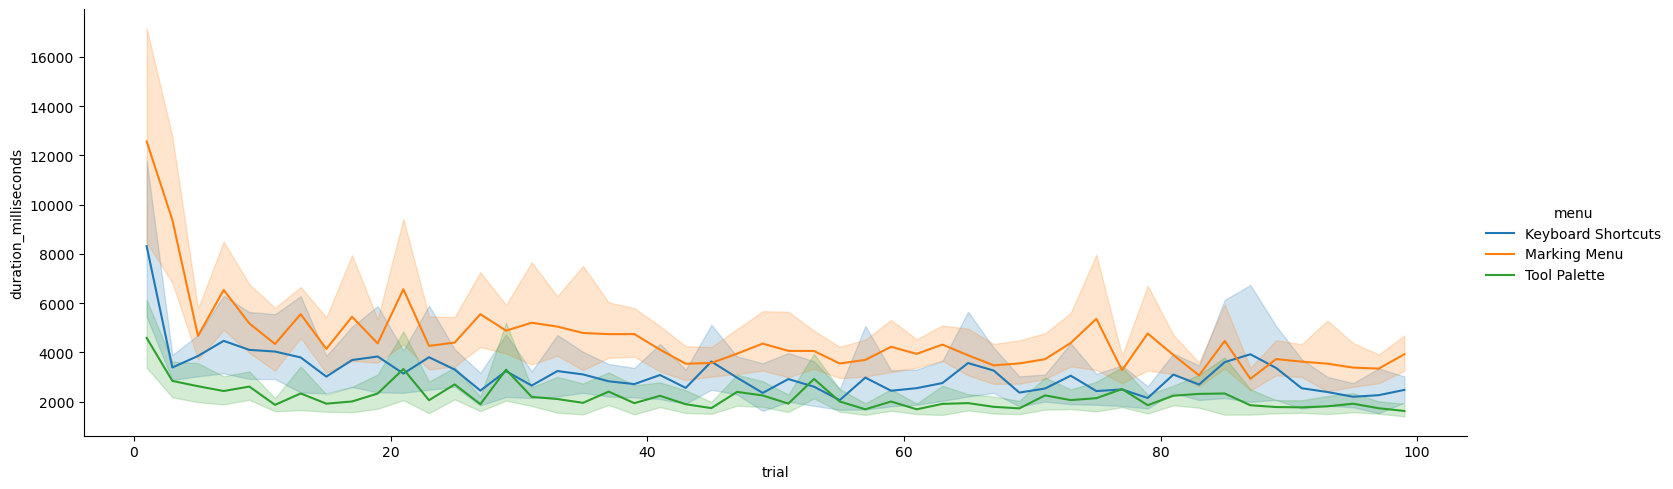

In [76]:
sns.relplot(data=selection,kind='line', x='trial', y='duration_milliseconds', hue="menu", height=5, aspect=15/5)

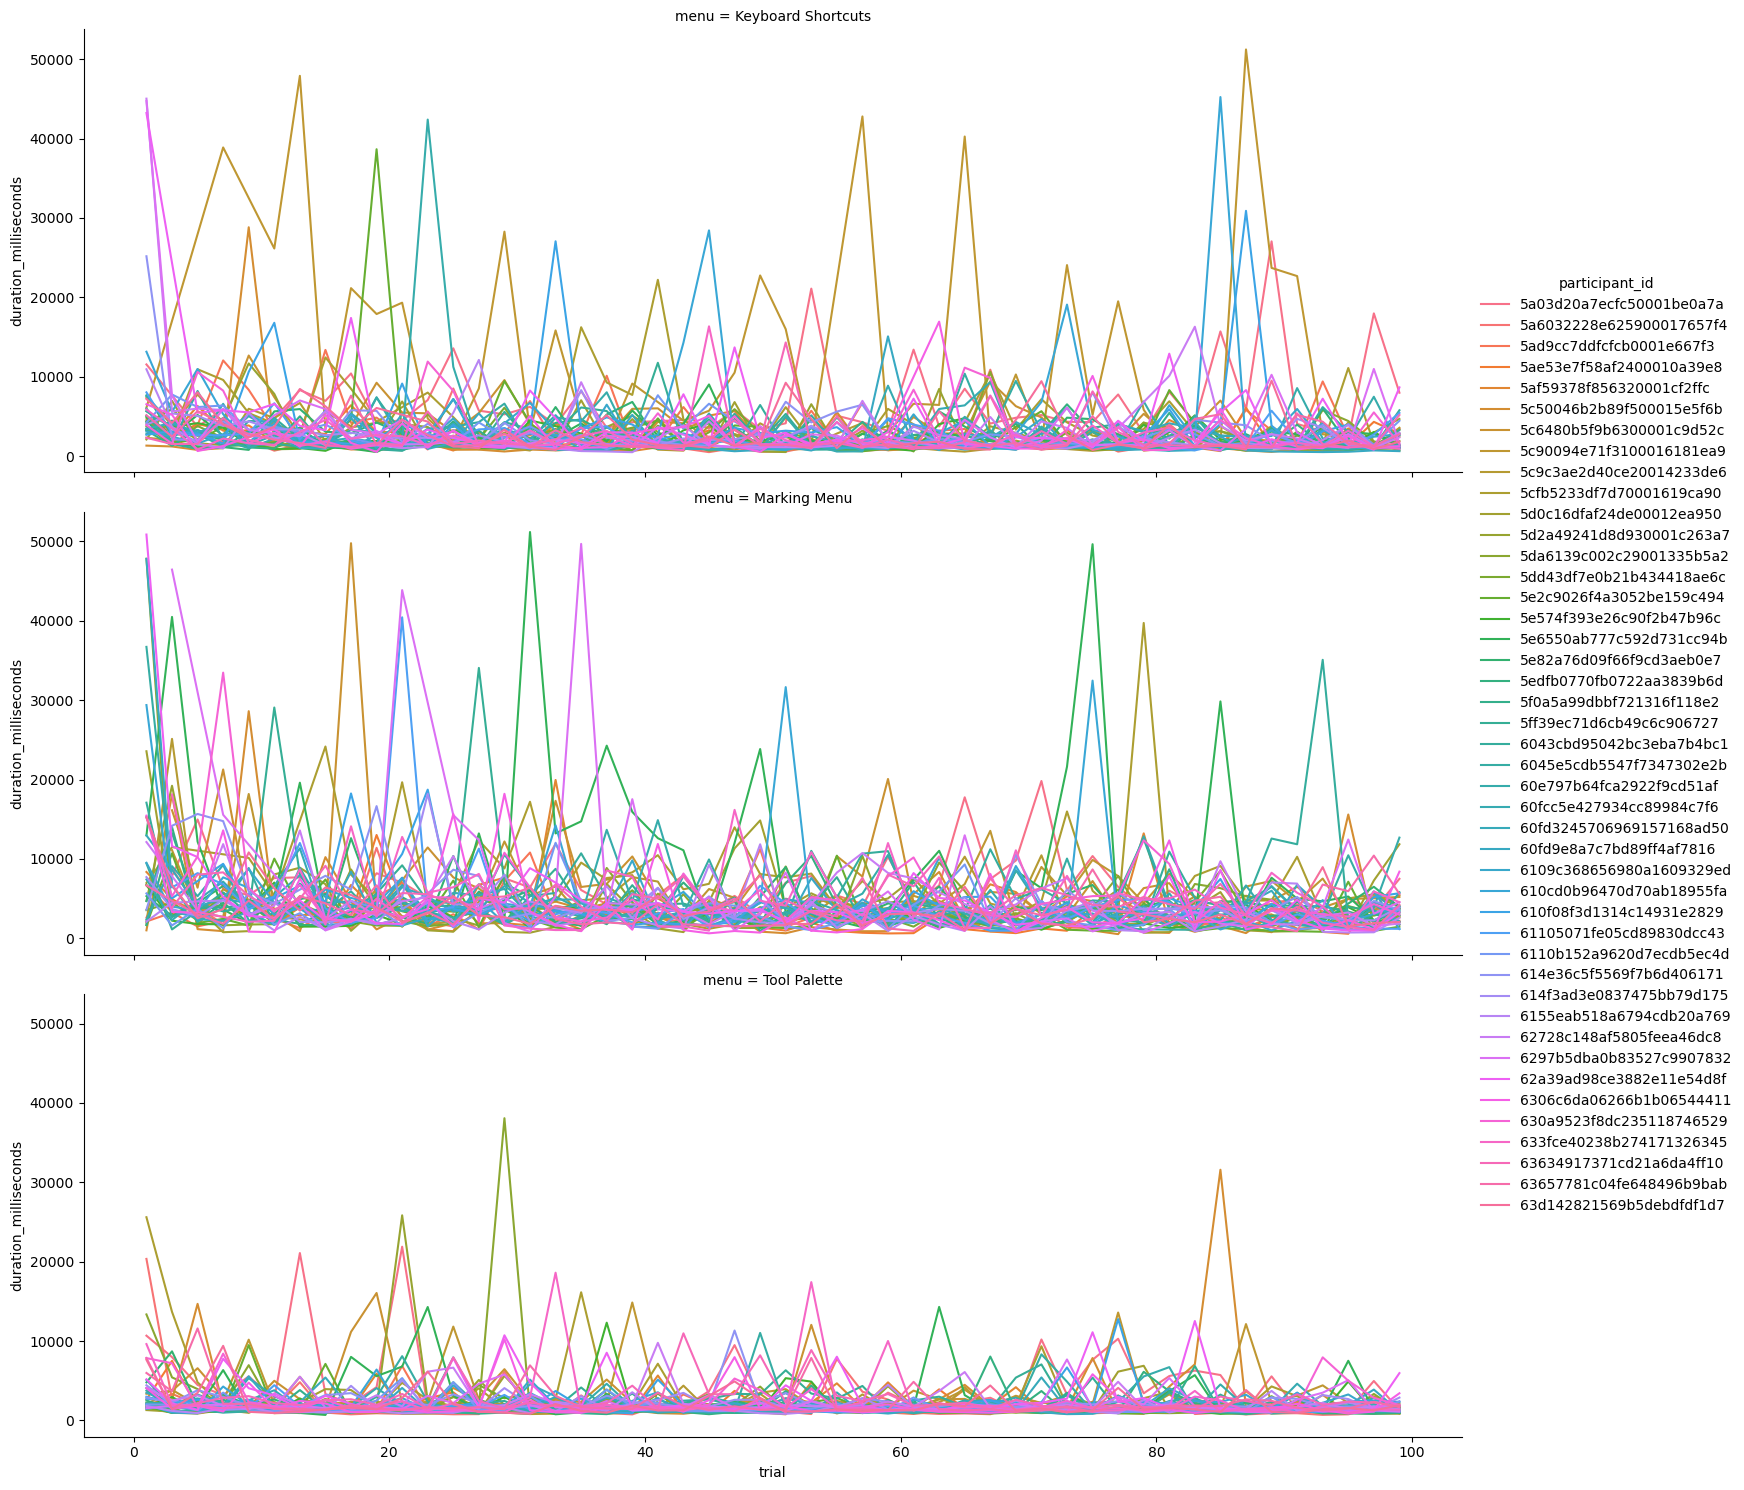

In [77]:
sns.relplot(data=selection, kind="line", x='trial', y='duration_milliseconds', row='menu', hue='participant_id', height=5, aspect=15/5)

## Creativity

In [78]:
unusual_uses = df[df['task'] == 'DivergentTest'].copy()

# unusual_uses.fillna({'menu':'baseline'}, inplace=True)

new_dfs = []

for index, row in unusual_uses.iterrows():
    for log in row['logs']:
        if log['type'] == 'DivergentTest':
#             print(row[['participant_id', 'menu', 'object']])
#             new_df = pd.DataFrame(log['values'], columns=['values'])
#             new_df = new_df.merge(pd.DataFrame(row), how='cross')
            rows = []
            for i, value in enumerate(log['values']):
                new_row = row.copy()
                new_row['topTwo'] = False if i >= len(log['topTwo']) or log['topTwo'][i] == None else log['topTwo'][i]
                new_row['value'] = value
                rows.append(new_row)
        
            
#             print(rows)

            # TODO: just need to pad the Nones with some falses to make things worlk
#             new_df.loc[list(map(bool, log['topTwo'])) + [False] * (len(log['values']) - len(log['topTwo'])), 'topTwo'] = True
            new_dfs.append(pd.DataFrame(rows))
            break
unusual_uses = pd.concat(new_dfs)
# def extract_unusual_uses(g):
#     for index, row in g.iterrows():
#         if not isinstance(row['logs'], list):
#             return pd.Series(pd.NA)

#         for log in row['logs']:
#             if log['type'] == 'DivergentTest':
#                 new_df = pd.DataFrame(log['values'], columns=['values'])
#                 new_df['topTwo'] = False
                
#                 # TODO: just need to pad the Nones with some falses to make things worlk
#                 new_df.loc[list(map(bool, log['topTwo'])) + [False] * (len(log['values']) - len(log['topTwo'])), 'topTwo'] = True
#                 return new_df
        
# unusual_uses = unusual_uses.groupby(['participant_id', 'menu', 'object']).apply(extract_unusual_uses).reset_index()
# del unusual_uses['level_3']
# del unusual_uses[0]

In [79]:
counts = unusual_uses.groupby(['participant_id', 'menu']).count()
# assert len(counts[counts['value'] <= 2]) == 0
counts[counts['value'] < 2]
# counts

,,order,metadata,version,tasks,ResolutionChecker,__INDEX__,participant_number,task,content,questions,...,Sex,Ethnicity simplified,Country of birth,Country of residence,Nationality,Language,Student status,Employment status,topTwo,value
participant_id,menu,,,,,,,,,,,,,,,,,,,,,
62a39ad98ce3882e11e54d8f,Tool Palette,1,1,1,1,1,1,1,1,0,0,...,1,1,1,1,1,1,1,1,1,1
63d142821569b5debdfdf1d7,Baseline,1,1,1,1,1,1,1,1,0,0,...,1,1,1,1,1,1,1,1,1,1


In [80]:
unusual_uses[unusual_uses['topTwo']].to_csv('./toptwo.csv', index=False)
display(FileLink('./toptwo.csv'))
unusual_uses[unusual_uses['topTwo']]

/Users/blainelewis/research/creativity-experiment/analysis/toptwo.csv

,order,participant_id,metadata,version,tasks,ResolutionChecker,__INDEX__,participant_number,task,content,...,Sex,Ethnicity simplified,Country of birth,Country of residence,Nationality,Language,Student status,Employment status,topTwo,value
3,"[""MarkingMenu"",""ToolPalette"",""KeyboardShortcut...",5a03d20a7ecfc50001be0a7a,"{""participant"":""ixkos2upfut-default"",""WORKER_I...",prolific-pilot@2,"[""ProgressBar"",""ResolutionChecker""]","{""minXResolution"":900,""minYResolution"":700}",[3],0,DivergentTest,NaN,...,Female,White,United States,United States,United States,English,DATA_EXPIRED,DATA_EXPIRED,True,to knead dough
3,"[""MarkingMenu"",""ToolPalette"",""KeyboardShortcut...",5a03d20a7ecfc50001be0a7a,"{""participant"":""ixkos2upfut-default"",""WORKER_I...",prolific-pilot@2,"[""ProgressBar"",""ResolutionChecker""]","{""minXResolution"":900,""minYResolution"":700}",[3],0,DivergentTest,NaN,...,Female,White,United States,United States,United States,English,DATA_EXPIRED,DATA_EXPIRED,True,as a hammer
106,"[""MarkingMenu"",""ToolPalette"",""KeyboardShortcut...",5a03d20a7ecfc50001be0a7a,"{""participant"":""ixkos2upfut-default"",""WORKER_I...",prolific-pilot@2,"[""ProgressBar"",""ResolutionChecker""]","{""minXResolution"":900,""minYResolution"":700}","[4, 3]",0,DivergentTest,NaN,...,Female,White,United States,United States,United States,English,DATA_EXPIRED,DATA_EXPIRED,True,to break apart drywall
106,"[""MarkingMenu"",""ToolPalette"",""KeyboardShortcut...",5a03d20a7ecfc50001be0a7a,"{""participant"":""ixkos2upfut-default"",""WORKER_I...",prolific-pilot@2,"[""ProgressBar"",""ResolutionChecker""]","{""minXResolution"":900,""minYResolution"":700}","[4, 3]",0,DivergentTest,NaN,...,Female,White,United States,United States,United States,English,DATA_EXPIRED,DATA_EXPIRED,True,to break into pieces and grind into powder and...
211,"[""MarkingMenu"",""ToolPalette"",""KeyboardShortcut...",5a03d20a7ecfc50001be0a7a,"{""participant"":""ixkos2upfut-default"",""WORKER_I...",prolific-pilot@2,"[""ProgressBar"",""ResolutionChecker""]","{""minXResolution"":900,""minYResolution"":700}","[5, 3]",0,DivergentTest,NaN,...,Female,White,United States,United States,United States,English,DATA_EXPIRED,DATA_EXPIRED,True,as a dance prop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13950,"[""KeyboardShortcutsWithCheatsheet"",""MarkingMen...",63d142821569b5debdfdf1d7,"{""participant"":""ory9xpo6r8f-default"",""WORKER_I...",prolific-pilot@2,"[""ProgressBar"",""ResolutionChecker""]","{""minXResolution"":900,""minYResolution"":700}","[4, 3]",43,DivergentTest,NaN,...,Male,Asian,India,United States,India,Tamil,Yes,Unemployed (and job seeking),True,spice
14055,"[""KeyboardShortcutsWithCheatsheet"",""MarkingMen...",63d142821569b5debdfdf1d7,"{""participant"":""ory9xpo6r8f-default"",""WORKER_I...",prolific-pilot@2,"[""ProgressBar"",""ResolutionChecker""]","{""minXResolution"":900,""minYResolution"":700}","[5, 3]",43,DivergentTest,NaN,...,Male,Asian,India,United States,India,Tamil,Yes,Unemployed (and job seeking),True,as a cover
14055,"[""KeyboardShortcutsWithCheatsheet"",""MarkingMen...",63d142821569b5debdfdf1d7,"{""participant"":""ory9xpo6r8f-default"",""WORKER_I...",prolific-pilot@2,"[""ProgressBar"",""ResolutionChecker""]","{""minXResolution"":900,""minYResolution"":700}","[5, 3]",43,DivergentTest,NaN,...,Male,Asian,India,United States,India,Tamil,Yes,Unemployed (and job seeking),True,surgery
14160,"[""KeyboardShortcutsWithCheatsheet"",""MarkingMen...",63d142821569b5debdfdf1d7,"{""participant"":""ory9xpo6r8f-default"",""WORKER_I...",prolific-pilot@2,"[""ProgressBar"",""ResolutionChecker""]","{""minXResolution"":900,""minYResolution"":700}","[6, 3]",43,DivergentTest,NaN,...,Male,Asian,India,United States,India,Tamil,Yes,Unemployed (and job seeking),True,weapon


In [81]:
unusual_counts = unusual_uses.groupby(['participant_id','menu', 'object']).count().reset_index()

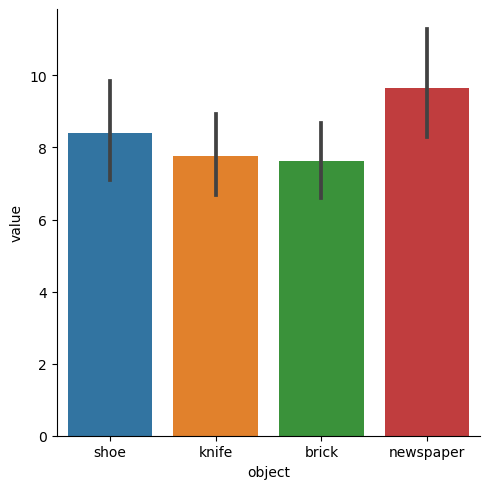

In [82]:
sns.catplot(data=unusual_counts, kind="bar", x='object', y='value')

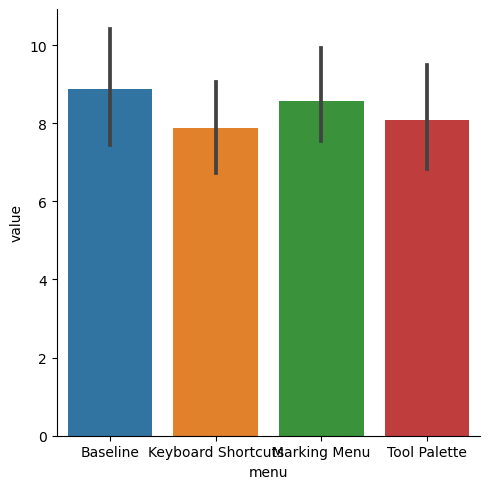

In [83]:
sns.catplot(data=unusual_counts, kind="bar", x='menu', y='value')

In [84]:
unusual_uses.groupby(['participant_id','menu']).count()

order  metadata  version  tasks  \
participant_id           menu                                                  
5a03d20a7ecfc50001be0a7a Baseline                4         4        4      4   
                         Keyboard Shortcuts      2         2        2      2   
                         Marking Menu            5         5        5      5   
                         Tool Palette            7         7        7      7   
5a6032228e625900017657f4 Baseline               20        20       20     20   
...                                            ...       ...      ...    ...   
63657781c04fe648496b9bab Tool Palette           14        14       14     14   
63d142821569b5debdfdf1d7 Baseline                1         1        1      1   
                         Keyboard Shortcuts      5         5        5      5   
                         Marking Menu            5         5        5      5   
                         Tool Palette            4         4        4      4   

                                             ResolutionChecker  __INDEX__  \
participant_id           menu                                               
5a03d20a7ecfc50001be0a7a Baseline                            4          4   
                         Keyboard Shortcuts                  2          2   
                         Marking Menu                        5          5   
                         Tool Palette                        7          7   
5a6032228e625900017657f4 Baseline                           20         20   
...                                                        ...        ...   
63657781c04fe648496b9bab Tool Palette                       14         14   
63d142821569b5debdfdf1d7 Baseline                            1          1   
                         Keyboard Shortcuts                  5          5   
                         Marking Menu                        5          5   
                         Tool Palette                        4          4   

                                             participant_number  task  \
participant_id           menu                                           
5a03d20a7ecfc50001be0a7a Baseline                             4     4   
                         Keyboard Shortcuts                   2     2   
                         Marking Menu                         5     5   
                         Tool Palette                         7     7   
5a6032228e625900017657f4 Baseline                            20    20   
...                                                         ...   ...   
63657781c04fe648496b9bab Tool Palette                        14    14   
63d142821569b5debdfdf1d7 Baseline                             1     1   
                         Keyboard Shortcuts                   5     5   
                         Marking Menu                         5     5   
                         Tool Palette                         4     4   

                                             content  questions  ...  Sex  \
participant_id           menu                                    ...        
5a03d20a7ecfc50001be0a7a Baseline                  0          0  ...    4   
                         Keyboard Shortcuts        0          0  ...    2   
                         Marking Menu              0          0  ...    5   
                         Tool Palette              0          0  ...    7   
5a6032228e625900017657f4 Baseline                  0          0  ...   20   
...                                              ...        ...  ...  ...   
63657781c04fe648496b9bab Tool Palette              0          0  ...   14   
63d142821569b5debdfdf1d7 Baseline                  0          0  ...    1   
                         Keyboard Shortcuts        0          0  ...    5   
                         Marking Menu              0          0  ...    5   
                         Tool Palette              0          0  ...    4   

                                             Ethni

In [85]:
unusual_uses.groupby(['menu','object']).count()

order  participant_id  metadata  version  tasks  \
menu               object                                                       
Baseline           brick         92              92        92       92     92   
                   knife         59              59        59       59     59   
                   newspaper    124             124       124      124    124   
                   shoe          98              98        98       98     98   
Keyboard Shortcuts brick        101             105       105      105    105   
                   knife        140             144       144      144    144   
                   newspaper     48              48        48       48     48   
                   shoe          50              50        50       50     50   
Marking Menu       brick         89              89        89       89     89   
                   knife         46              46        46       46     46   
                   newspaper    106             113       113      113    113   
                   shoe         125             129       129      129    129   
Tool Palette       brick         47              49        49       49     49   
                   knife         88              93        93       93     93   
                   newspaper    130             130       130      130    130   
                   shoe          84              84        84       84     84   

                              ResolutionChecker  __INDEX__  \
menu               object                                    
Baseline           brick                     92         92   
                   knife                     59         59   
                   newspaper                124        124   
                   shoe                      98         98   
Keyboard Shortcuts brick                    105        105   
                   knife                    144        144   
                   newspaper                 48         48   
                   shoe                      50         50   
Marking Menu       brick                     89         89   
                   knife                     46         46   
                   newspaper                113        113   
                   shoe                     129        129   
Tool Palette       brick                     49         49   
                   knife                     93         93   
                   newspaper                130        130   
                   shoe                      84         84   

                              participant_number  task  content  ...  Sex  \
menu               object                                        ...        
Baseline           brick                      92    92        0  ...   92   
                   knife                      59    59        0  ...   59   
                   newspaper                 124   124        0  ...  124   
                   shoe                       98    98        0  ...   98   
Keyboard Shortcuts brick                     105   105        0  ...  105   
                   knife                     144   144        0  ...  144   
                   newspaper                  48    48        0  ...   48   
                   shoe                       50    50        0  ...   50   
Marking Menu       brick                      89    89        0  ...   89   
                   knife                      46    46        0  ...   46   
                   newspaper                 113   113        0  ...  113   
                   shoe                      129   129        0  ...  129   
Tool Palette       brick                      49    49        0  ...   49   
                   knife                      93    93        0  ...   93   
                   newspaper                 130   130        0  ...  130   
                   shoe                       84    84        0  ...   84   

                              Ethnicity simplified  Country of birt

In [90]:
from collections import defaultdict

participants = defaultdict(lambda: defaultdict(lambda: {'Keyboard Shortcuts' : 0, 'Marking Menu' : 0,'Tool Palette' :0, 'Baseline' : 0}))
for index,row in unusual_counts.iterrows():
    participants[row['participant_id']][row['menu']] = row['value']
    
for participant, counts in participants.items():
    for menu, count in counts.items():
        if count < 2:
            print(participant, menu, count)

62a39ad98ce3882e11e54d8f Tool Palette 1
63d142821569b5debdfdf1d7 Baseline 1


In [91]:
tlx = df[df['task'] == 'NasaTlx']


def extract_tlx(row):
    if not isinstance(row['logs'], list):
        return pd.Series(pd.NA)
    
    for log in row['logs']:
        if log['type'] == 'NasaTlx':
            return pd.Series(log['responses'])
tlx = pd.concat([tlx, tlx.apply(extract_tlx, axis=1)], axis=1)

metrics = 'Mental Demand	Physical Demand	Temporal Demand	Performance	Effort	Frustration'.split('	')

melted_tlx = pd.melt(tlx, id_vars=list(set(tlx.columns) - set(metrics)), value_vars=metrics)

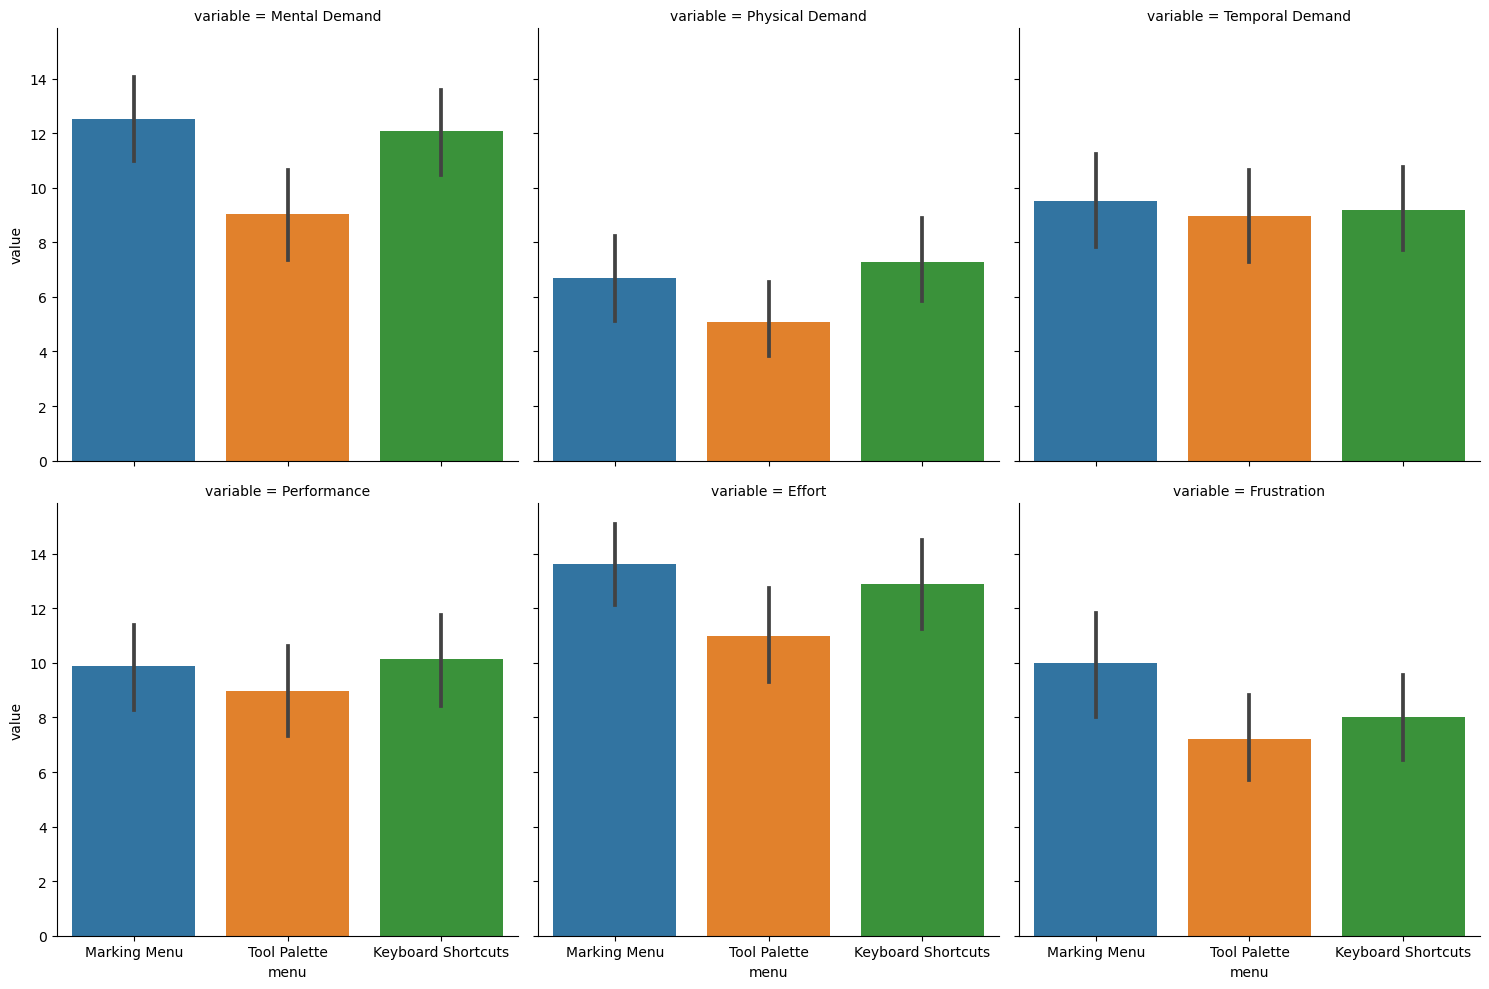

In [92]:
sns.catplot(data=melted_tlx, kind="bar", x='menu', y='value', col="variable", col_wrap=3)

In [93]:
questionnaire = df[df['task'] == 'Questionnaire']

def extract_questionnaire(row):
    if not isinstance(row['logs'], list):
        return pd.Series(pd.NA)

    for log in row['logs']:
        if log['type'] == 'QuestionnaireResponses':
            return pd.Series(log['responses'])
        
questionnaire = pd.concat([questionnaire, questionnaire.apply(extract_questionnaire, axis=1)], axis=1)
# questionnaire['felt'] = questionnaire['I felt creative while I was selecting commands.']
# questionnaire['use'] = questionnaire['I would like to use that command selection technique while doing a creative task like drawing or writing a story.']



In [94]:
questionnaire[questionnaire['felt'].isna()]

,order,participant_id,metadata,version,tasks,ResolutionChecker,__INDEX__,participant_number,task,content,...,Sex,Ethnicity simplified,Country of birth,Country of residence,Nationality,Language,Student status,Employment status,felt,imagine


## I felt creative while I was selecting commands.

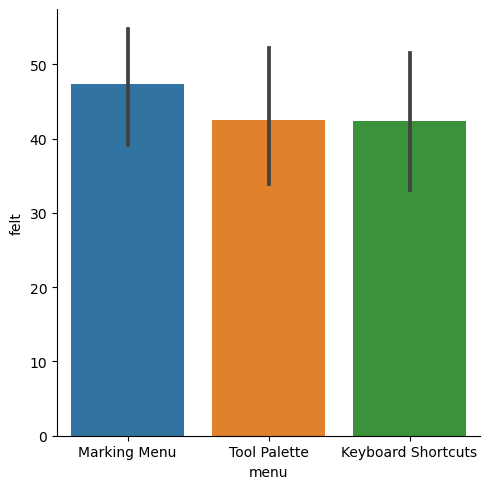

In [95]:
sns.catplot(data=questionnaire, kind="bar", x='menu', y='felt')

In [114]:
stats.friedmanchisquare(questionnaire[questionnaire['menu'] == 'Marking Menu']['felt'], 
                        questionnaire[questionnaire['menu'] == 'Tool Palette']['felt'], 
                        questionnaire[questionnaire['menu'] == 'Keyboard Shortcuts']['felt'])

FriedmanchisquareResult(statistic=1.3292682926829378, pvalue=0.5144617109798997)

## I would like to use that command selection technique while doing a creative task like drawing or writing a story.

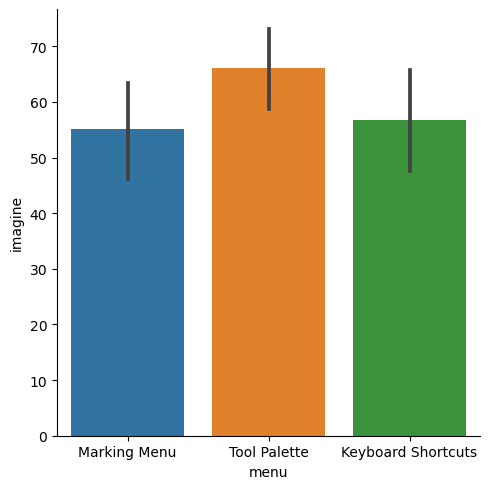

In [115]:
sns.catplot(data=questionnaire, kind="bar", x='menu', y='imagine')

In [116]:
stats.friedmanchisquare(questionnaire[questionnaire['menu'] == 'Marking Menu']['imagine'], 
                        questionnaire[questionnaire['menu'] == 'Tool Palette']['imagine'], 
                        questionnaire[questionnaire['menu'] == 'Keyboard Shortcuts']['imagine'])

FriedmanchisquareResult(statistic=7.9176470588235075, pvalue=0.019085554682537774)

In [97]:
comments = df[df['task'] == 'AdditionalComments'].copy()

def find_log(logs):
    for log in logs:
        if log['type'] == 'COMMENTS':
            return log['data']
        
comments['comments'] = comments['logs'].map(find_log)


comments.style.set_properties(subset=['comments'], **{'width': '800px'})
comments[['comments']]


,comments
319,
641,thanks for opportunity
963,"the mouse select one lagged a lot, and if I di..."
1606,
1928,
2250,It was different and very interesting. I learn...
2572,n/a
2894,
3216,No issues.
3538,Thank you for allowing me to participate in yo...


In [98]:
mouse_positioning = df[df['task'] == 'MousePositioning'].copy()

def extract_selection(row):
    errors = 0
    start = None
    end = None
    for log in row['logs']:
        if log['type'] == 'WRONG_COMMAND':
            errors += 1
        if log['type'] == 'START':
            start = log['timestamp']
        if log['type'] == 'END':
            end = log['timestamp']
    row['errors'] = errors
    row['has_error'] = errors > 0
    row['duration_milliseconds'] = end - start
    row['duration_minutes'] = row['duration_milliseconds'] / 1000 / 60
    return row

mouse_positioning['trial'] = mouse_positioning['__INDEX__'].map(lambda x: x[2])
mouse_positioning['trial_total'] = mouse_positioning['__INDEX__'].map(lambda x: x[0] * x[1])

mouse_positioning = mouse_positioning[['participant_id', '__INDEX__', 'logs', 'command', 'trial','trial_total', 'menu']]

mouse_positioning = mouse_positioning.apply(extract_selection, axis=1)
mouse_positioning['menu'] = mouse_positioning.menu.astype("category")

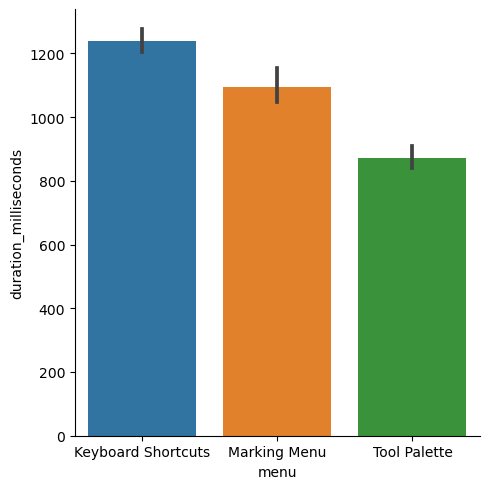

In [99]:
sns.catplot(data=mouse_positioning, kind="bar", x='menu', y='duration_milliseconds')

/var/folders/6y/lbzmz4lj6xb8933np1_x1xgm0000gn/T/ipykernel_6492/1319584353.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.catplot(data=mouse_positioning.groupby(['participant_id','menu']).sum().reset_index(), kind="bar", x='menu', y='duration_minutes')


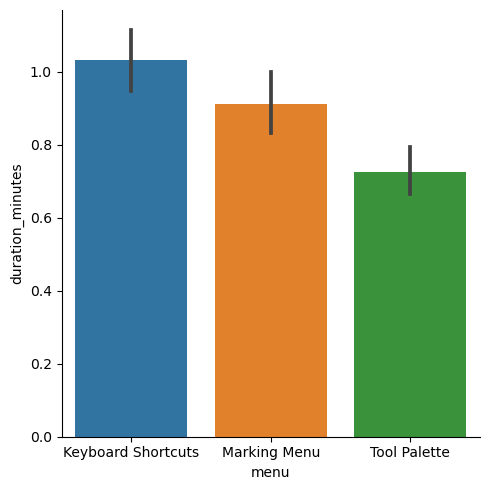

In [100]:
sns.catplot(data=mouse_positioning.groupby(['participant_id','menu']).sum().reset_index(), kind="bar", x='menu', y='duration_minutes')

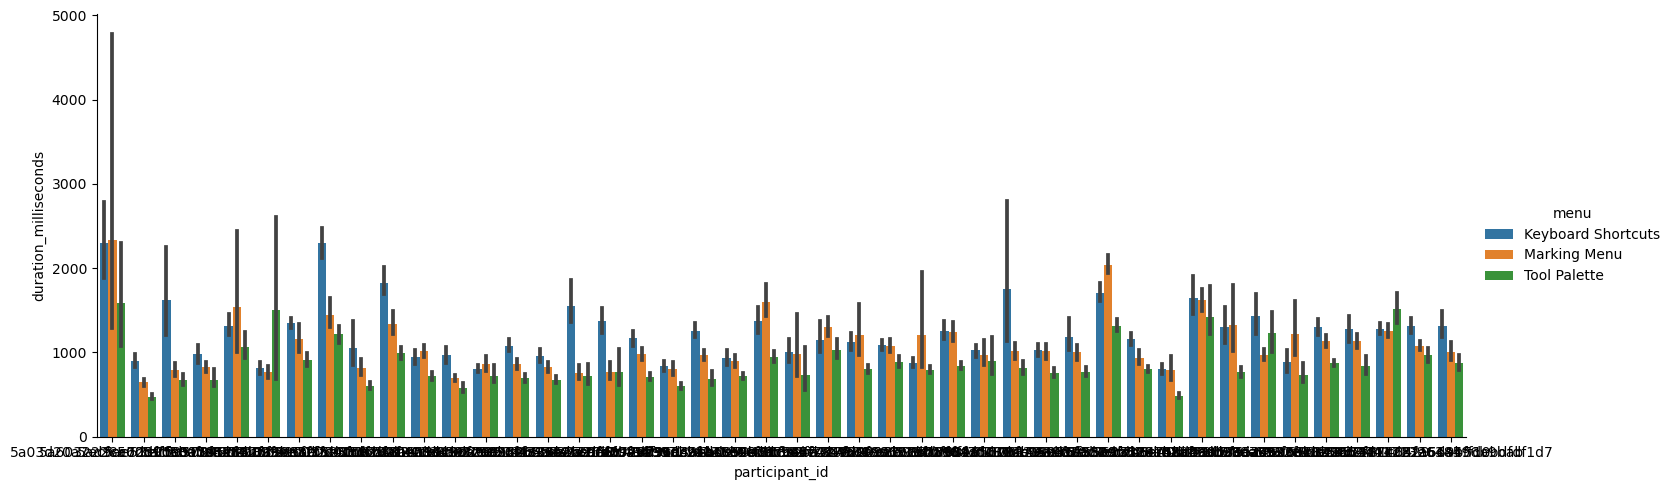

In [103]:
sns.catplot(data=mouse_positioning, kind="bar", hue="menu", x='participant_id', y='duration_milliseconds', height=5, aspect=15/5)

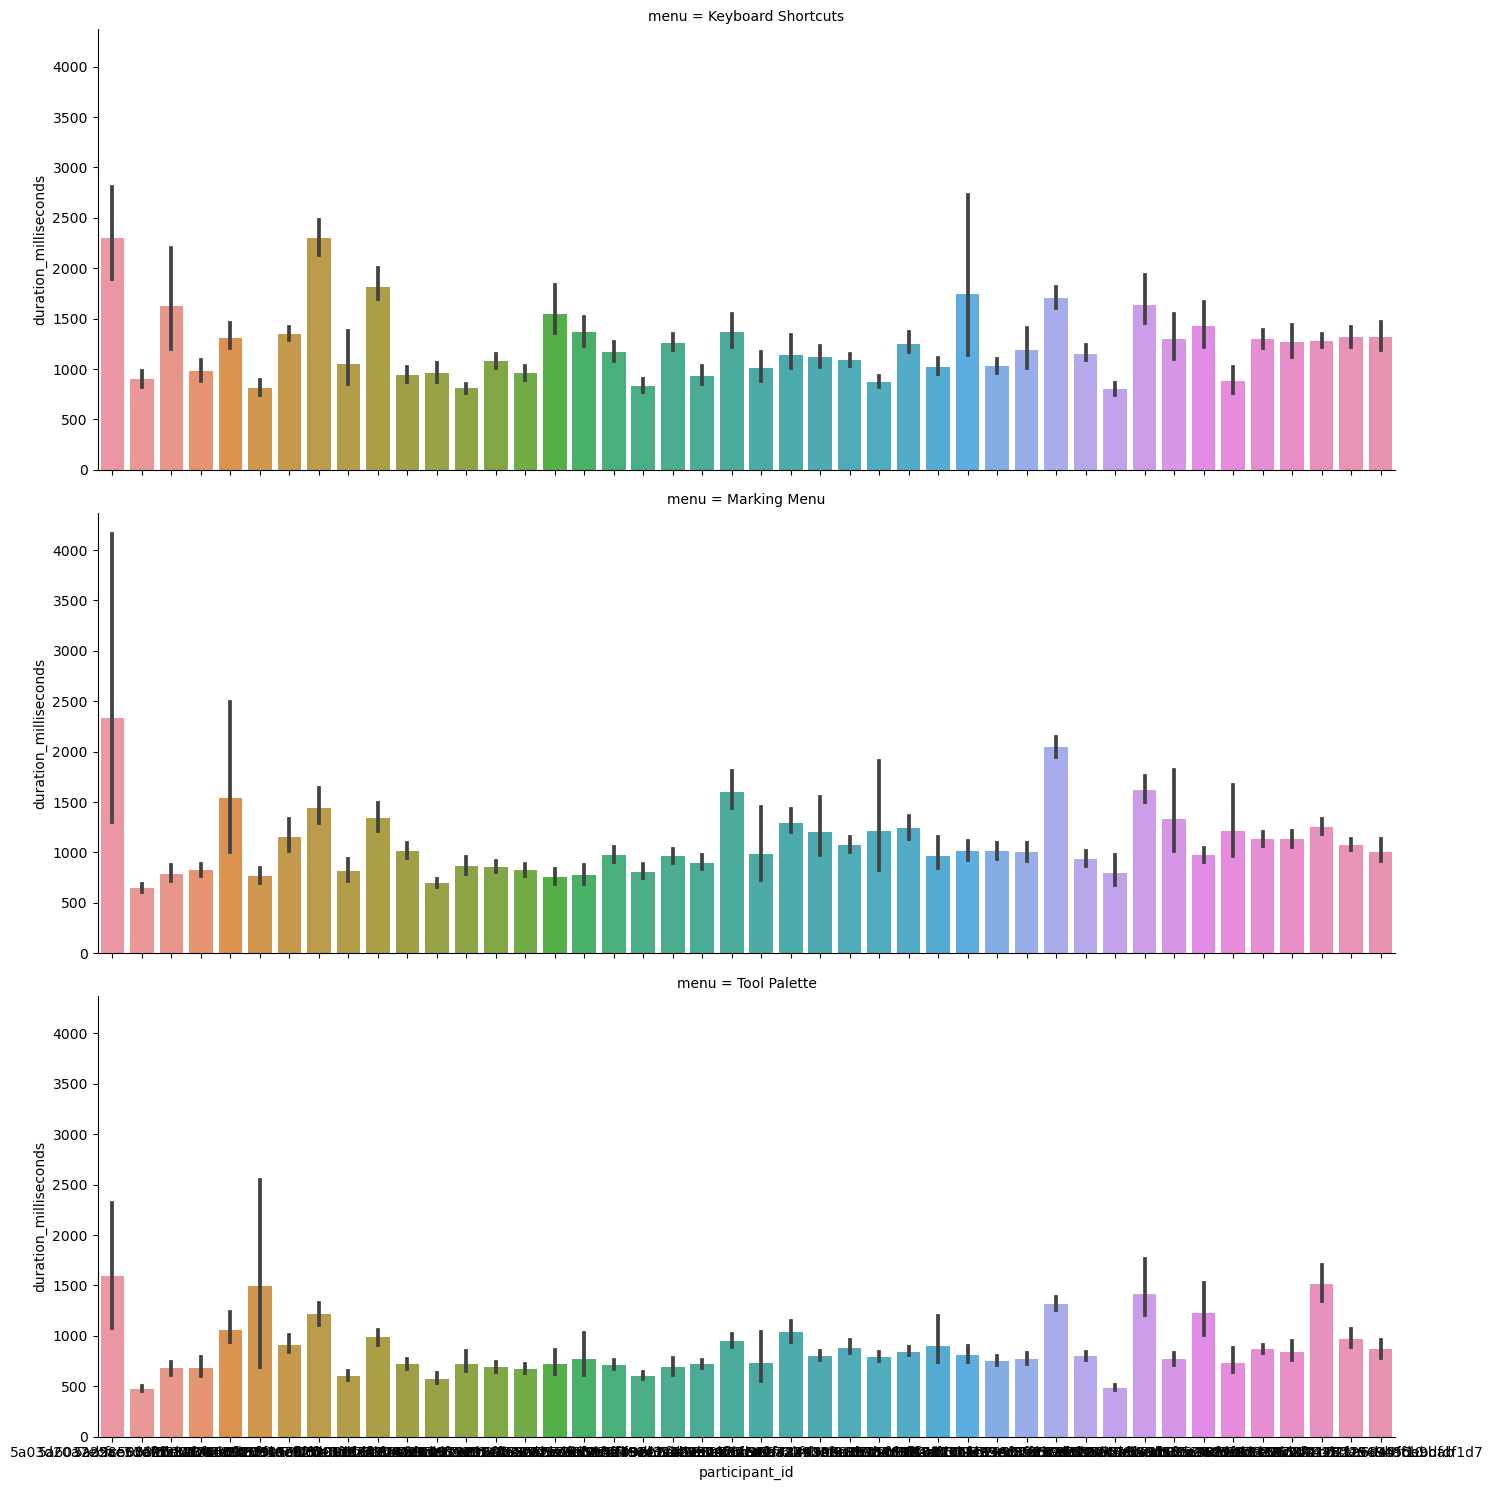

In [104]:
sns.catplot(data=mouse_positioning, kind="bar", x='participant_id', y='duration_milliseconds', row='menu', height=5, aspect=15/5)

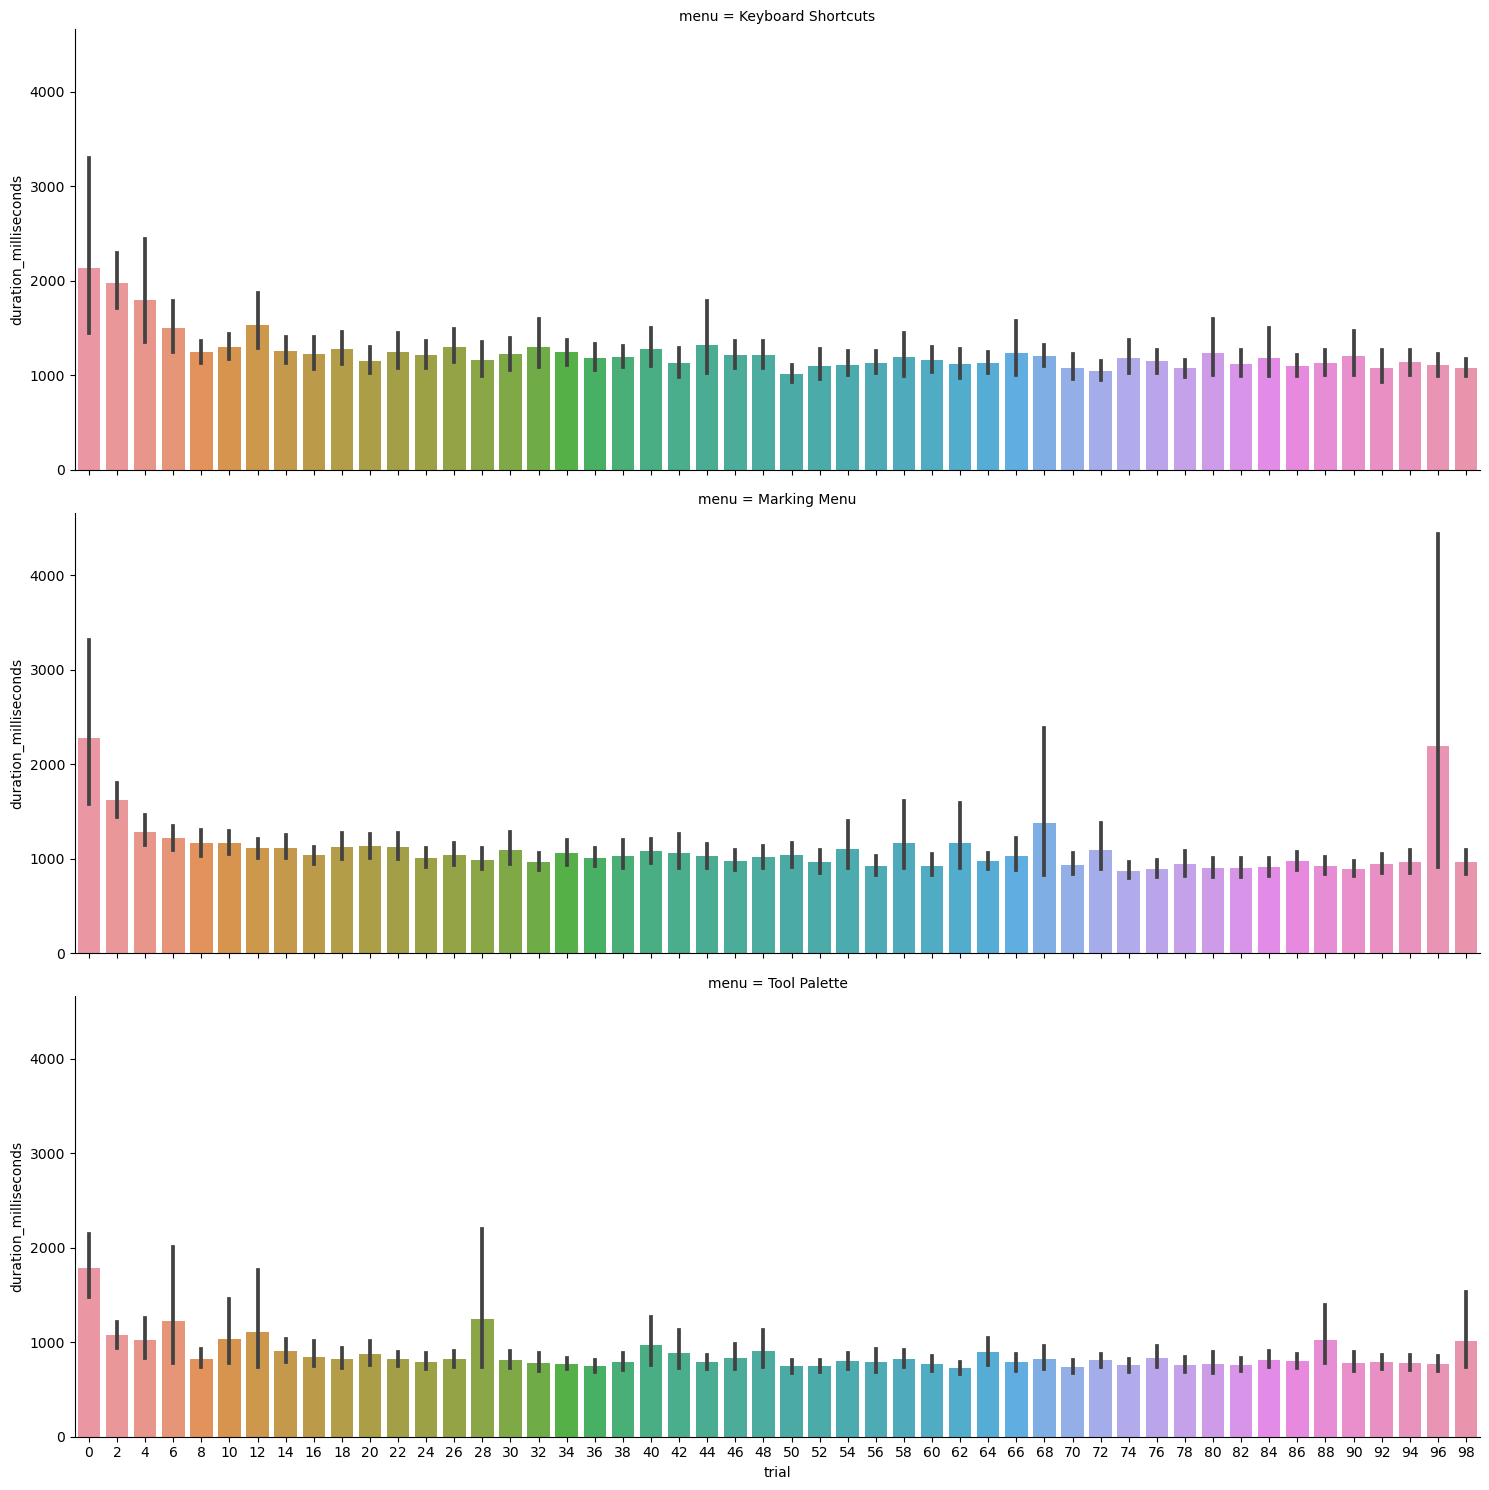

In [ ]:
sns.catplot(data=mouse_positioning, kind="bar", x='trial', y='duration_milliseconds', row='menu', height=5, aspect=15/5)

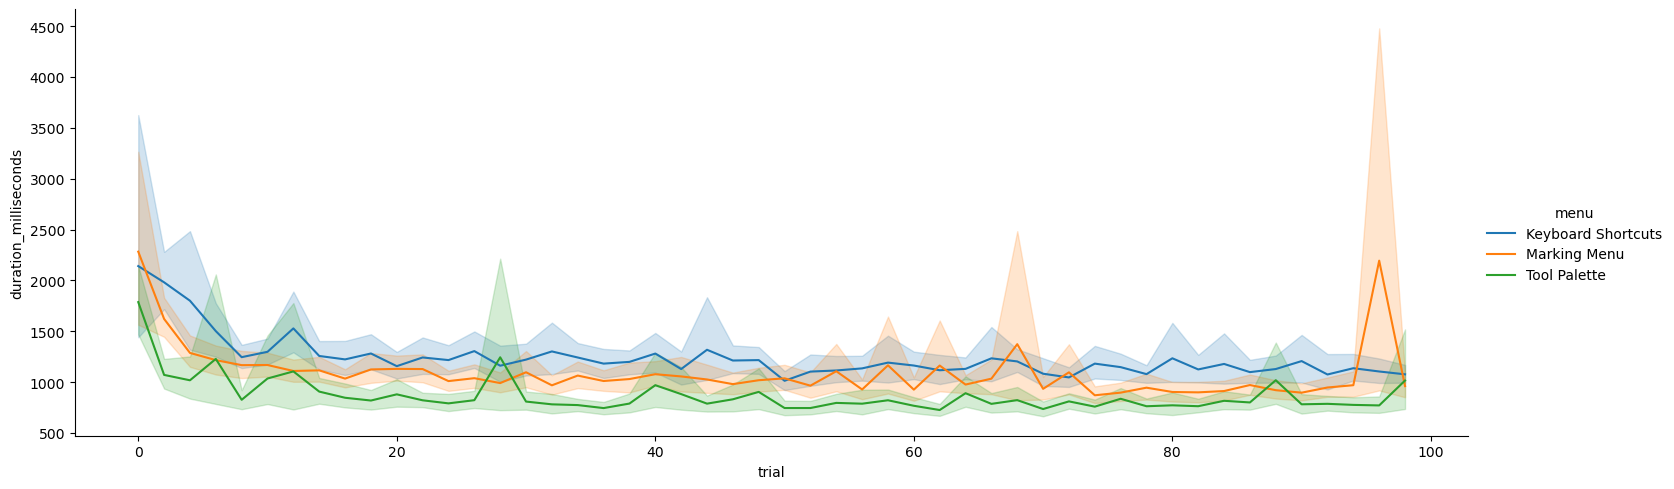

In [107]:
sns.relplot(data=mouse_positioning,kind='line', x='trial', y='duration_milliseconds', hue="menu", height=5, aspect=15/5)

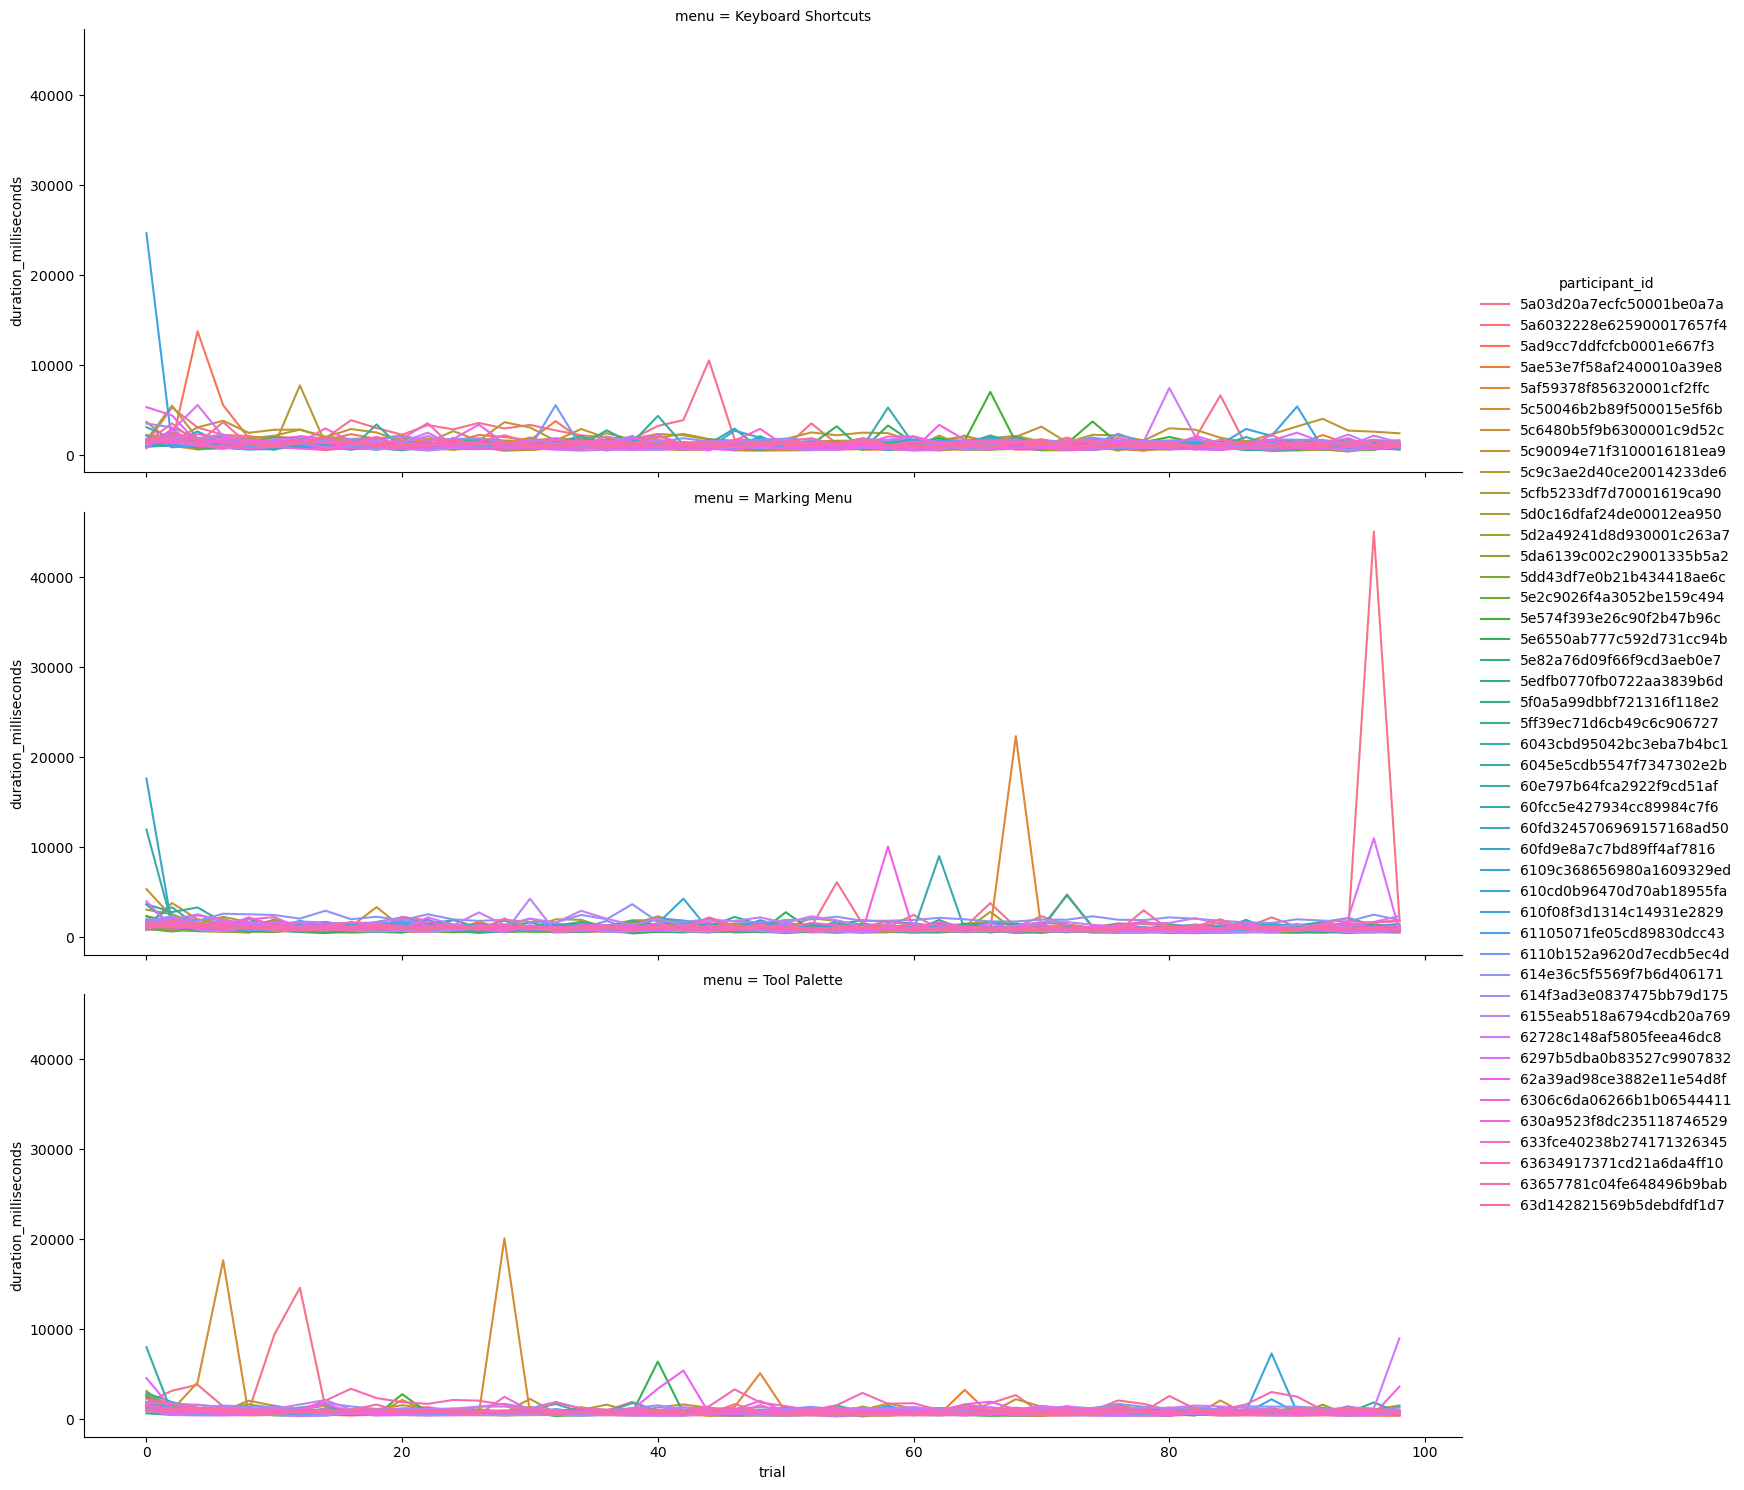

In [108]:
sns.relplot(data=mouse_positioning, kind="line", x='trial', y='duration_milliseconds', row='menu', hue='participant_id', height=5, aspect=15/5)